# Energy A.I. Hackathon 2026 Workflow - Prosper Petroleum Engineering
Authors: Vivaan Moharir, Saksham Agarwal, Sanjay Rajjan, Tejas Dasa, Puranjay Prashanth Departments and Schools: Statistics and Data Science - CNS, Mathematics - CNS, Computer Science - CNS, Petroleum Engineering - Cockrell, Electrical and Computer Engineering - Cockrell The University of Texas at Austin, Austin, Texas, USA

### Executive Summary
Accurate oil production forecasting for infill wells is hindered by sparse well log data and noisy seismic attributes. Our team engineered a physics-informed machine learning pipeline using Bagged XGBoost and spatial denoising techniques to predict cumulative production. We learned that integrating domain-specific features like Reservoir Quality Index significantly outperforms raw data models, achieving a Test R² of 0.9095. Going forward, we recommend using this ensemble model for robust field planning while continuously calibrating uncertainty bounds with new drilling data.

### Workflow Goal
To predict 3-year cumulative oil production for pre-production wells with high accuracy and quantify geological risk through a calibrated uncertainty model.

### Workflow Steps
Data Analysis - Cleaned production time-series data, corrected column formatting, and applied Gaussian/Median filters to denoise the 2D seismic sand map.

Feature Selection - Engineered 16 high-value features by aggregating well logs (P10/P90 statistics), deriving physics-based proxies (RQI, Heterogeneity), and extracting spatial sand attributes.

Machine Learning Model #1 - Predict 3-Year Cumulative Oil Production from Geological and Spatial Features using a Bagged XGBoost Ensemble (10 seeds) to ensure stability and minimize variance.

Uncertainty Quantification - Generated 100 probabilistic realizations via Bootstrap resampling to capture epistemic uncertainty and define P10-P90 confidence intervals.

## Environment Initialization

Standard data science libraries provide the foundation for matrix manipulation and plotting. Setting display options early ensures that large dataframes remain readable during inspection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
print("Libraries loaded successfully!")

Libraries loaded successfully!


## Data Ingestion

The project data resides in multiple CSV files: well logs (sensor readings), production history (target variables), and a sand proportion map (spatial context). Loading these into memory creates the raw materials for analysis.

In [2]:
well_logs_prod = pd.read_csv('Well_log_data_production_wells.csv')
well_logs_preprod = pd.read_csv('Well_log_data_preproduction_wells.csv')
production_history = pd.read_csv('Production_history_production_wells.csv')
sand_proportion = np.load('2d_sand_proportion.npy')
print(f"Production Well Logs: {well_logs_prod.shape}")
print(f"Preproduction Well Logs: {well_logs_preprod.shape}")
print(f"Production History: {production_history.shape}")
print(f"Sand Proportion Map: {sand_proportion.shape}")

Production Well Logs: (1491, 22)
Preproduction Well Logs: (252, 22)
Production History: (5517, 5)
Sand Proportion Map: (200, 200)


### Calculation Logic

This block executes a specific mathematical transformation required to prepare the data for the next stage.

In [3]:
print("=" * 60)
print("PRODUCTION WELLS LOG DATA")
print("=" * 60)
print(f"\nShape: {well_logs_prod.shape}")
print(f"\nColumns: {list(well_logs_prod.columns)}")
print(f"\nData Types:\n{well_logs_prod.dtypes}")
print(f"\nUnique Well IDs: {well_logs_prod['Well_ID'].unique()}")
print(f"Number of unique wells: {well_logs_prod['Well_ID'].nunique()}")

PRODUCTION WELLS LOG DATA

Shape: (1491, 22)

Columns: ['Well_ID', 'X', 'Y', 'Z', 'AI', 'SI', 'Vp', 'Vs', 'rho_b', 'rho_f', 'rho_m', 'K0', 'Kdry', 'Kf', 'Ksat', 'G0', 'Gdry', 'Gsat', 'facies', 'phi', 'perm', 'GR']

Data Types:
Well_ID      int64
X            int64
Y            int64
Z            int64
AI         float64
SI         float64
Vp         float64
Vs         float64
rho_b      float64
rho_f      float64
rho_m      float64
K0         float64
Kdry       float64
Kf         float64
Ksat       float64
G0         float64
Gdry       float64
Gsat       float64
facies     float64
phi        float64
perm       float64
GR         float64
dtype: object

Unique Well IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Number of unique wells: 71


### Vertical Coverage Check

Since these are vertical wells, consistency in depth measurement is vital. Comparing the minimum and maximum depth values across wells confirms that the dataset covers a uniform geological window.

In [4]:
print("Depth (Z) Statistics per Well:")
depth_stats = well_logs_prod.groupby('Well_ID')['Z'].agg(['min', 'max', 'count'])
print(depth_stats.describe())
print(f"\nDepth range: {well_logs_prod['Z'].min()} to {well_logs_prod['Z'].max()}")
print(f"Rows per well (should be consistent): {well_logs_prod.groupby('Well_ID').size().unique()}")

Depth (Z) Statistics per Well:
        min   max  count
count  71.0  71.0   71.0
mean   19.0  39.0   21.0
std     0.0   0.0    0.0
min    19.0  39.0   21.0
25%    19.0  39.0   21.0
50%    19.0  39.0   21.0
75%    19.0  39.0   21.0
max    19.0  39.0   21.0

Depth range: 19 to 39
Rows per well (should be consistent): [21]


### Calculation Logic

This block executes a specific mathematical transformation required to prepare the data for the next stage.

In [5]:
print("=" * 60)
print("PRODUCTION HISTORY DATA")
print("=" * 60)
production_history['Date'] = pd.to_datetime(production_history['Date'])
print(f"\nShape: {production_history.shape}")
print(f"\nColumns: {list(production_history.columns)}")
print(f"\nDate range: {production_history['Date'].min()} to {production_history['Date'].max()}")
print(f"\nUnique wells: {production_history['Well_ID'].nunique()}")

PRODUCTION HISTORY DATA

Shape: (5517, 5)

Columns: ['Well_ID', 'Date', 'Cumulative Gas Production, ft3', 'Cumulative Oil Production, BBL', 'Cumulative Water Production, BBL']

Date range: 2019-01-01 00:00:00 to 2025-11-01 00:00:00

Unique wells: 71


### Operational Timeline

Visualizing the start dates reveals the history of the drilling operations. Clusters of activity might indicate specific campaigns, while gaps could suggest operational pauses.

Well Production Start Dates:
    Well_ID Start_Date
0         1 2019-01-01
48       49 2019-01-01
54       55 2019-01-01
55       56 2019-01-01
56       57 2019-01-01
57       58 2019-01-01
58       59 2019-01-01
59       60 2019-01-01
60       61 2019-01-01
49       50 2019-01-01
50       51 2019-01-01
1         2 2019-01-01
4         5 2019-01-01
2         3 2019-01-01
3         4 2019-01-01
11       12 2019-04-01
61       62 2019-04-01
62       63 2019-04-01
63       64 2019-04-01
64       65 2019-04-01
65       66 2019-04-01
66       67 2019-04-01
67       68 2019-04-01
10       11 2019-04-01
6         7 2019-04-01
5         6 2019-04-01
9        10 2019-04-01
53       54 2019-04-01
52       53 2019-04-01
51       52 2019-04-01
19       20 2019-04-01
18       19 2019-04-01
17       18 2019-04-01
16       17 2019-04-01
15       16 2019-04-01
14       15 2019-04-01
13       14 2019-04-01
12       13 2019-04-01
8         9 2019-04-01
7         8 2019-04-01
25       26 2019-08-01
28   

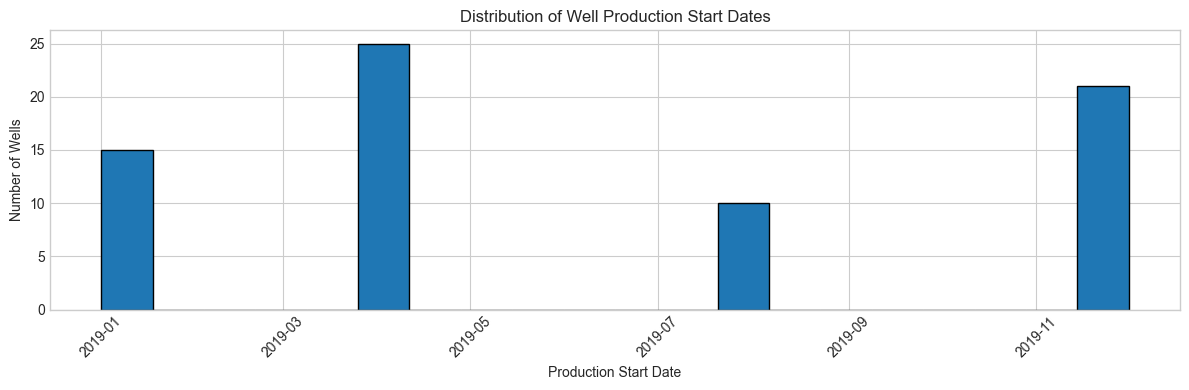

In [6]:
well_start_dates = production_history.groupby('Well_ID')['Date'].min().reset_index()
well_start_dates.columns = ['Well_ID', 'Start_Date']
print("Well Production Start Dates:")
print(well_start_dates.sort_values('Start_Date'))
plt.figure(figsize=(12, 4))
plt.hist(well_start_dates['Start_Date'], bins=20, edgecolor='black')
plt.xlabel('Production Start Date')
plt.ylabel('Number of Wells')
plt.title('Distribution of Well Production Start Dates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Diagnostic: Missing Data

Sensor data is prone to gaps. Quantifying the percentage of missing values in each column distinguishes between minor data loss and systemic sensor failure.

In [7]:
def analyze_missing_values(df, name):
    """Comprehensive missing value analysis"""
    print(f"\n{'='*60}")
    print(f"MISSING VALUE ANALYSIS: {name}")
    print(f"{'='*60}")
    missing_counts = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing %': missing_pct
    }).sort_values('Missing %', ascending=False)
    print("\nMissing Values by Column:")
    print(missing_df[missing_df['Missing Count'] > 0])
    return missing_df
missing_prod = analyze_missing_values(well_logs_prod, "Production Well Logs")
missing_preprod = analyze_missing_values(well_logs_preprod, "Preproduction Well Logs")
missing_history = analyze_missing_values(production_history, "Production History")


MISSING VALUE ANALYSIS: Production Well Logs

Missing Values by Column:
        Missing Count  Missing %
facies            143   9.590879
Kdry              142   9.523810
Gsat              137   9.188464
rho_b             136   9.121395
G0                135   9.054326
Vs                130   8.718981
Gdry              128   8.584842
Ksat              126   8.450704
GR                124   8.316566
SI                120   8.048290
K0                119   7.981221
phi               116   7.780013
AI                104   6.975184
rho_m             102   6.841046
rho_f              66   4.426559
perm               63   4.225352
Vp                 61   4.091214
Kf                 48   3.219316

MISSING VALUE ANALYSIS: Preproduction Well Logs

Missing Values by Column:
        Missing Count  Missing %
K0                 24   9.523810
SI                 23   9.126984
Ksat               23   9.126984
Gsat               23   9.126984
rho_m              23   9.126984
AI                 22   8.

### Visualizing Data Gaps

A heatmap provides a spatial view of where data is missing. This reveals whether the gaps are random noise or concentrated in specific wells or depth intervals.

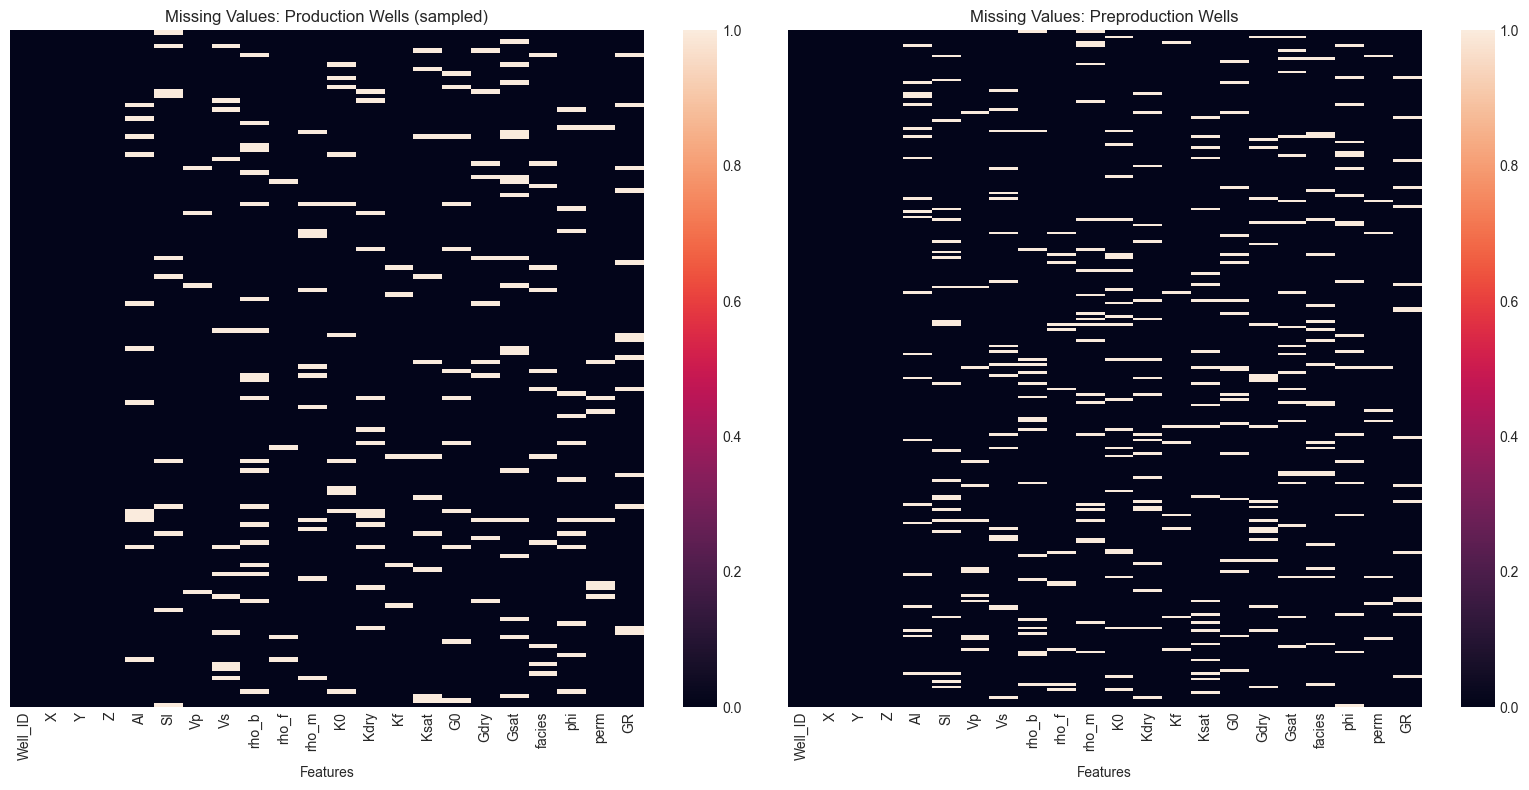

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sample_prod = well_logs_prod.iloc[::10] 
sns.heatmap(sample_prod.isnull(), cbar=True, yticklabels=False, ax=axes[0])
axes[0].set_title('Missing Values: Production Wells (sampled)')
axes[0].set_xlabel('Features')
sns.heatmap(well_logs_preprod.isnull(), cbar=True, yticklabels=False, ax=axes[1])
axes[1].set_title('Missing Values: Preproduction Wells')
axes[1].set_xlabel('Features')
plt.tight_layout()
plt.show()

### Well-Level Integrity

Aggregating missing values by Well ID identifies specific instances that are too corrupted to use. Excluding wells with majority-missing logs prevents them from degrading the model's performance.

In [9]:
def missing_by_well(df, name):
    """Check if certain wells have more missing data"""
    missing_per_well = df.groupby('Well_ID').apply(lambda x: x.isnull().sum().sum())
    total_values_per_well = df.groupby('Well_ID').size() * (df.shape[1] - 1) 
    missing_pct_per_well = (missing_per_well / total_values_per_well * 100).round(2)
    print(f"\n{name} - Missing % by Well:")
    print(f"Mean: {missing_pct_per_well.mean():.2f}%")
    print(f"Max: {missing_pct_per_well.max():.2f}% (Well {missing_pct_per_well.idxmax()})")
    print(f"Min: {missing_pct_per_well.min():.2f}% (Well {missing_pct_per_well.idxmin()})")
    return missing_pct_per_well
missing_by_well_prod = missing_by_well(well_logs_prod, "Production Wells")
missing_by_well_preprod = missing_by_well(well_logs_preprod, "Preproduction Wells")


Production Wells - Missing % by Well:
Mean: 6.39%
Max: 9.52% (Well 68)
Min: 3.17% (Well 31)

Preproduction Wells - Missing % by Well:
Mean: 6.44%
Max: 8.39% (Well 82)
Min: 4.76% (Well 74)


## Feature Taxonomy

Grouping variables by their physical properties (like 'Elastic' vs. 'Reservoir') allows for targeted cleaning strategies. Different physical measurements often require different imputation logic.

In [10]:
FEATURE_CATEGORIES = {
    'identifiers': ['Well_ID', 'X', 'Y', 'Z'],
    'elastic_properties': ['AI', 'SI', 'Vp', 'Vs'], 
    'density': ['rho_b', 'rho_f', 'rho_m'], 
    'moduli': ['K0', 'Kdry', 'Kf', 'Ksat', 'G0', 'Gdry', 'Gsat'], 
    'reservoir': ['facies', 'phi', 'perm', 'GR'], 
}
print("Feature Categories Defined:")
for cat, features in FEATURE_CATEGORIES.items():
    print(f"  {cat}: {features}")

Feature Categories Defined:
  identifiers: ['Well_ID', 'X', 'Y', 'Z']
  elastic_properties: ['AI', 'SI', 'Vp', 'Vs']
  density: ['rho_b', 'rho_f', 'rho_m']
  moduli: ['K0', 'Kdry', 'Kf', 'Ksat', 'G0', 'Gdry', 'Gsat']
  reservoir: ['facies', 'phi', 'perm', 'GR']


## Environment Initialization

Standard data science libraries provide the foundation for matrix manipulation and plotting. Setting display options early ensures that large dataframes remain readable during inspection.

In [11]:
import pandas as pd
import numpy as np
def impute_well_logs(df, method='interpolate'):
    """
    Impute missing values in well log data using domain-appropriate methods.
    UPDATED: Compatible with Pandas 2.0+ (replaced .fillna(method=...) with .ffill()/.bfill())
    """
    df_clean = df.copy()
    imputation_flags = pd.DataFrame(index=df.index)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ['Well_ID', 'X', 'Y', 'Z']]
    for col in numeric_cols:
        imputation_flags[f'{col}_imputed'] = df[col].isnull().astype(int)
        if col == 'facies':
            df_clean[col] = df.groupby('Well_ID')[col].transform(
                lambda x: x.ffill().bfill().fillna(
                    x.mode().iloc[0] if len(x.mode()) > 0 else x.median()
                )
            )
        else:
            df_clean[col] = df.groupby('Well_ID')[col].transform(
                lambda x: x.interpolate(method='linear').bfill().ffill()
            )
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            global_median = df[col].median()
            df_clean[col] = df_clean[col].fillna(global_median)
            print(f"  Warning: {col} had wells with all missing - used global median {global_median:.4f}")
    return df_clean, imputation_flags
print("Imputing Production Well Logs...")
well_logs_prod_clean, flags_prod = impute_well_logs(well_logs_prod)
print("\nImputing Preproduction Well Logs...")
well_logs_preprod_clean, flags_preprod = impute_well_logs(well_logs_preprod)
print(f"\nRemaining NaN in production logs: {well_logs_prod_clean.isnull().sum().sum()}")
print(f"Remaining NaN in preproduction logs: {well_logs_preprod_clean.isnull().sum().sum()}")

Imputing Production Well Logs...

Imputing Preproduction Well Logs...

Remaining NaN in production logs: 0
Remaining NaN in preproduction logs: 0


## Target Construction

The prediction goal is the 3-year cumulative oil production. Summing the first 36 months of monthly production data creates a single, robust target variable for each well.

In [12]:
def calculate_3yr_cumulative_oil(production_df):
    """
    Calculate 3-year cumulative oil production for each well.
    Uses the first 36 months of production for each well.
    Note: The competition scores predictions against Dec 1, 2022 - Dec 1, 2025
    but for training, we use each well's actual 3-year production.
    """
    results = []
    for well_id in production_df['Well_ID'].unique():
        well_data = production_df[production_df['Well_ID'] == well_id].sort_values('Date')
        start_date = well_data['Date'].min()
        end_date_3yr = start_date + pd.DateOffset(years=3)
        well_3yr = well_data[well_data['Date'] <= end_date_3yr]
        if len(well_3yr) > 0:
            cum_oil_3yr = well_3yr['Cumulative Oil Production, BBL'].iloc[-1]
            months_available = len(well_3yr)
        else:
            cum_oil_3yr = np.nan
            months_available = 0
        results.append({
            'Well_ID': well_id,
            'Start_Date': start_date,
            'Cum_Oil_3yr': cum_oil_3yr,
            'Months_Available': months_available
        })
    return pd.DataFrame(results)
target_df = calculate_3yr_cumulative_oil(production_history)
print("3-Year Cumulative Oil Production Summary:")
print(target_df.describe())
print(f"\nWells with full 36 months: {(target_df['Months_Available'] >= 36).sum()}")
print(f"Wells with < 36 months: {(target_df['Months_Available'] < 36).sum()}")

3-Year Cumulative Oil Production Summary:
         Well_ID                  Start_Date   Cum_Oil_3yr  Months_Available
count  71.000000                          71  7.100000e+01              71.0
mean   36.000000  2019-06-10 08:06:45.633802  3.337814e+07              37.0
min     1.000000         2019-01-01 00:00:00  8.242955e+06              37.0
25%    18.500000         2019-04-01 00:00:00  2.300844e+07              37.0
50%    36.000000         2019-04-01 00:00:00  3.345851e+07              37.0
75%    53.500000         2019-12-01 00:00:00  4.148532e+07              37.0
max    71.000000         2019-12-01 00:00:00  7.402141e+07              37.0
std    20.639767                         NaN  1.414892e+07               0.0

Wells with full 36 months: 71
Wells with < 36 months: 0


### Data Visualization

Visual inspection of the data distribution highlights patterns and potential outliers that raw statistics might miss.

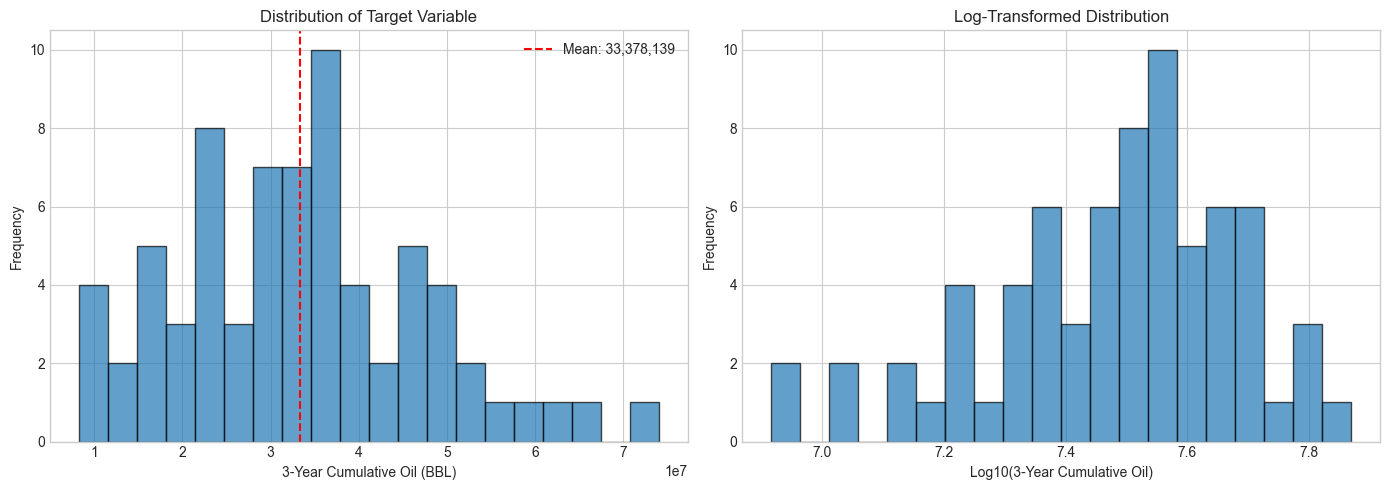

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(target_df['Cum_Oil_3yr'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('3-Year Cumulative Oil (BBL)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Target Variable')
axes[0].axvline(target_df['Cum_Oil_3yr'].mean(), color='r', linestyle='--', label=f"Mean: {target_df['Cum_Oil_3yr'].mean():,.0f}")
axes[0].legend()
axes[1].hist(np.log10(target_df['Cum_Oil_3yr']), bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log10(3-Year Cumulative Oil)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Distribution')
plt.tight_layout()
plt.show()

### Aggregation Analysis

Grouping the data allows for the analysis of trends across specific categories or subsets.

In [14]:
def aggregate_well_logs(df):
    """
    Aggregate depth-indexed well logs to well-level features.
    Creates statistical summaries for each log property.
    """
    log_features = [col for col in df.columns if col not in ['Well_ID', 'X', 'Y', 'Z']]
    agg_dict = {}
    for feat in log_features:
        agg_dict[feat] = ['mean', 'std', 'min', 'max', 
                         lambda x: x.quantile(0.1),  
                         lambda x: x.quantile(0.5),  
                         lambda x: x.quantile(0.9)]  
    agg_dict['X'] = 'first'
    agg_dict['Y'] = 'first'
    df_agg = df.groupby('Well_ID').agg(agg_dict)
    df_agg.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] 
                      for col in df_agg.columns.values]
    df_agg.columns = [col.replace('<lambda_0>', 'p10').replace('<lambda_1>', 'p50').replace('<lambda_2>', 'p90')
                      for col in df_agg.columns]
    df_agg = df_agg.reset_index()
    return df_agg
print("Aggregating production well logs...")
features_prod = aggregate_well_logs(well_logs_prod_clean)
print(f"Shape: {features_prod.shape}")
print("\nAggregating preproduction well logs...")
features_preprod = aggregate_well_logs(well_logs_preprod_clean)
print(f"Shape: {features_preprod.shape}")
print(f"\nFeatures created: {features_prod.shape[1] - 1}") 


Aggregating production well logs...
Shape: (71, 129)

Aggregating preproduction well logs...
Shape: (12, 129)

Features created: 128


### Calculation Logic

This block executes a specific mathematical transformation required to prepare the data for the next stage.

In [15]:
def add_reservoir_features(df):
    """
    Add domain-specific derived features.
    """
    df = df.copy()
    if 'perm_mean' in df.columns and 'perm_std' in df.columns:
        df['perm_cv'] = df['perm_std'] / df['perm_mean'] 
    if 'phi_mean' in df.columns and 'phi_std' in df.columns:
        df['phi_cv'] = df['phi_std'] / df['phi_mean'] 
    if 'perm_mean' in df.columns and 'phi_mean' in df.columns:
        df['RQI'] = 0.0314 * np.sqrt(df['perm_mean'] / df['phi_mean'])
    if 'perm_p90' in df.columns and 'perm_p10' in df.columns:
        df['perm_range_ratio'] = df['perm_p90'] / (df['perm_p10'] + 1e-6) 
    return df
features_prod = add_reservoir_features(features_prod)
features_preprod = add_reservoir_features(features_preprod)
print("Added derived features. New shape:", features_prod.shape)

Added derived features. New shape: (71, 133)


### Spatial Feature Engineering

Integrating the sand proportion map adds a horizontal dimension to the vertical well data. Smoothing this map and extracting values at well coordinates provides context about the surrounding reservoir quality.

In [16]:
def extract_sand_proportion(df, sand_map):
    """
    Extract sand proportion value at each well's (X, Y) location from the 2D map.
    """
    df = df.copy()
    sand_values = []
    for _, row in df.iterrows():
        x, y = int(row['X']), int(row['Y'])
        x = min(max(x, 0), sand_map.shape[0] - 1)
        y = min(max(y, 0), sand_map.shape[1] - 1)
        sand_values.append(sand_map[x, y])
    df['sand_proportion'] = sand_values
    return df
features_prod = extract_sand_proportion(features_prod, sand_proportion)
features_preprod = extract_sand_proportion(features_preprod, sand_proportion)
print("Added sand proportion from seismic map.")
print(f"Sand proportion range: {features_prod['sand_proportion'].min():.3f} - {features_prod['sand_proportion'].max():.3f}")

Added sand proportion from seismic map.
Sand proportion range: 0.623 - 0.624


### Data Structure Preview

A quick look at the first few rows confirms the dataframe is structured correctly and the data types appear as expected.

In [17]:
training_data = features_prod.merge(target_df[['Well_ID', 'Cum_Oil_3yr', 'Start_Date']], 
                                     on='Well_ID', how='left')
print(f"Training data shape: {training_data.shape}")
print(f"Target variable available for {training_data['Cum_Oil_3yr'].notna().sum()} wells")
print("\nSample of training data:")
training_data.head()

Training data shape: (71, 136)
Target variable available for 71 wells

Sample of training data:


,Well_ID,AI_mean,AI_std,AI_min,AI_max,AI_p10,AI_p50,AI_p90,SI_mean,SI_std,SI_min,SI_max,SI_p10,SI_p50,SI_p90,Vp_mean,Vp_std,Vp_min,Vp_max,Vp_p10,Vp_p50,Vp_p90,Vs_mean,Vs_std,Vs_min,Vs_max,Vs_p10,Vs_p50,Vs_p90,rho_b_mean,rho_b_std,rho_b_min,rho_b_max,rho_b_p10,rho_b_p50,rho_b_p90,rho_f_mean,rho_f_std,rho_f_min,rho_f_max,rho_f_p10,rho_f_p50,rho_f_p90,rho_m_mean,rho_m_std,rho_m_min,rho_m_max,rho_m_p10,rho_m_p50,rho_m_p90,K0_mean,K0_std,K0_min,K0_max,K0_p10,K0_p50,K0_p90,Kdry_mean,Kdry_std,Kdry_min,Kdry_max,Kdry_p10,Kdry_p50,Kdry_p90,Kf_mean,Kf_std,Kf_min,Kf_max,Kf_p10,Kf_p50,Kf_p90,Ksat_mean,Ksat_std,Ksat_min,Ksat_max,Ksat_p10,Ksat_p50,Ksat_p90,G0_mean,G0_std,G0_min,G0_max,G0_p10,G0_p50,G0_p90,Gdry_mean,Gdry_std,Gdry_min,Gdry_max,Gdry_p10,Gdry_p50,Gdry_p90,Gsat_mean,Gsat_std,Gsat_min,Gsat_max,Gsat_p10,Gsat_p50,Gsat_p90,facies_mean,facies_std,facies_min,facies_max,facies_p10,facies_p50,facies_p90,phi_mean,phi_std,phi_min,phi_max,phi_p10,phi_p50,phi_p90,perm_mean,perm_std,perm_min,perm_max,perm_p10,perm_p50,perm_p90,GR_mean,GR_std,GR_min,GR_max,GR_p10,GR_p50,GR_p90,X,Y,perm_cv,phi_cv,RQI,perm_range_ratio,sand_proportion,Cum_Oil_3yr,Start_Date
0,1,5.004644e+06,1.262124e+06,3959245.75,7219024.0,4007927.375,4309400.50,7199923.00,2.369729e+06,729846.310770,1823787.250,3770280.750,1842986.625,1993866.125,3753484.000,2201.743202,435.268831,1849.957275,2972.544189,1863.966919,1957.994019,2966.507812,1041.510893,262.794407,852.164429,1549.403809,858.095337,905.921326,1544.438354,2.252320,0.111509,2.140182,2.430323,2.148507,2.200926,2.426620,0.956024,0.048510,0.912139,1.031302,0.915601,0.927497,1.031188,2.646021,0.002701,2.639686,2.647629,2.640423,2.647532,2.647606,36.835746,1.794096,32.359550,37.690659,32.945099,37.674667,37.689613,2.488212,1.702811,1.245263,5.423145,1.266997,1.440156,5.404085,1.593635,0.283291,1.357274,2.054320,1.370785,1.419344,2.053309,8.007804,3.382996,5.252213,13.689069,5.353523,6.029399,13.595289,37.562216,7.051602,22.127697,41.978302,23.269091,41.832878,41.944130,2.558245,1.487108,1.554167,5.853251,1.584246,1.806286,5.797025,2.655137,1.624949,1.564655,5.853251,1.581458,1.806286,5.797025,2.476190,0.749603,2.0,4.0,2.0,2.0,4.0,0.231240,0.061529,0.131763,0.292394,0.134142,0.259649,0.287902,872.985617,517.581799,128.040537,1503.421850,135.188548,1032.373810,1442.041576,33.669921,12.589930,21.724576,64.492799,23.444378,28.509719,58.695883,33,127,0.592887,0.266085,1.929311,10.666891,0.624487,37316576.0,2019-01-01
1,2,4.315845e+06,8.520242e+05,3783827.75,6855845.0,3854698.875,4090256.75,4209156.00,2.057214e+06,528933.813018,1734713.000,3633872.000,1775230.000,1925581.750,1978710.750,1969.914347,300.127969,1797.259033,2868.143311,1816.791992,1886.007446,1923.883911,937.043871,195.158442,823.961609,1520.151367,837.726379,886.843445,904.555603,2.180245,0.074262,2.105332,2.390467,2.119105,2.168276,2.188029,0.915363,0.029102,0.899287,1.004795,0.900187,0.907197,0.911226,2.647663,0.000808,2.645230,2.647979,2.647873,2.647918,2.647972,37.545659,0.142325,37.115936,37.602367,37.575321,37.590454,37.600899,1.580113,0.913614,1.137343,5.119735,1.180199,1.346828,1.408651,1.381634,0.148246,1.309357,1.843701,1.312603,1.338439,1.353755,6.050656,2.079311,5.011724,12.312778,5.011724,5.443358,5.711835,41.607194,2.569105,33.873447,42.505695,42.351315,42.422157,42.484776,2.027164,1.166098,1.429337,5.524035,1.487157,1.707690,1.794795,2.026714,1.166243,1.429337,5.524035,1.487157,1.707690,1.794795,2.095238,0.300793,2.0,3.0,2.0,2.0,2.0,0.266016,0.041884,0.154808,0.311739,0.218527,0.274318,0.303725,1234.271081,409.529767,209.063643,1845.592223,1089.602556,1228.956220,1697.615816,28.062837,4.962438,19.723476,36.407123,22.603195,27.355176,34.829869,71,53,0.331799,0.157448,2.138854,1.558014,0.624090,47946168.0,2019-01-01
2,3,3.963661e+06,1.642382e+05,3772805.75,4195747.0,3780163.250,3961211.50,4167123.25,1.825888e+06,136774.975683,1680271.500,2032216.125,1680350.500,1812766.250,2007452.625,1851.040917,45.510337,1797.182007,1913.802612,1800.406616,1852.265

## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

In [18]:
feature_cols = [col for col in training_data.columns 
                if col not in ['Well_ID', 'Cum_Oil_3yr', 'Start_Date', 'X', 'Y']]
correlations = pd.DataFrame({
    'Feature': feature_cols,
    'Pearson': [training_data[col].corr(training_data['Cum_Oil_3yr']) for col in feature_cols],
    'Spearman': [training_data[col].corr(training_data['Cum_Oil_3yr'], method='spearman') for col in feature_cols]
})
correlations['Abs_Pearson'] = correlations['Pearson'].abs()
correlations['Abs_Spearman'] = correlations['Spearman'].abs()
correlations = correlations.sort_values('Abs_Spearman', ascending=False)
print("Top 20 Features by Correlation with 3-Year Cumulative Oil:")
print(correlations.head(20).to_string(index=False))

Top 20 Features by Correlation with 3-Year Cumulative Oil:
   Feature   Pearson  Spearman  Abs_Pearson  Abs_Spearman
 perm_mean  0.939789  0.957243     0.939789      0.957243
  phi_mean  0.912184  0.950402     0.912184      0.950402
rho_b_mean -0.904977 -0.947082     0.904977      0.947082
 rho_b_p50 -0.831986 -0.945305     0.831986      0.945305
    AI_p50 -0.809021 -0.944467     0.809021      0.944467
  Kdry_p50 -0.772761 -0.943830     0.772761      0.943830
   phi_p50  0.844486  0.943696     0.844486      0.943696
  perm_p50  0.920276  0.943494     0.920276      0.943494
    Vp_p50 -0.807140 -0.942455     0.807140      0.942455
       RQI  0.912043  0.941180     0.912043      0.941180
    SI_p50 -0.846019 -0.940275     0.846019      0.940275
  Gdry_p50 -0.833053 -0.939705     0.833053      0.939705
  Gsat_p50 -0.832887 -0.939269     0.832887      0.939269
   SI_mean -0.902740 -0.936117     0.902740      0.936117
  Ksat_p50 -0.762743 -0.935949     0.762743      0.935949
   AI_mean -0

## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

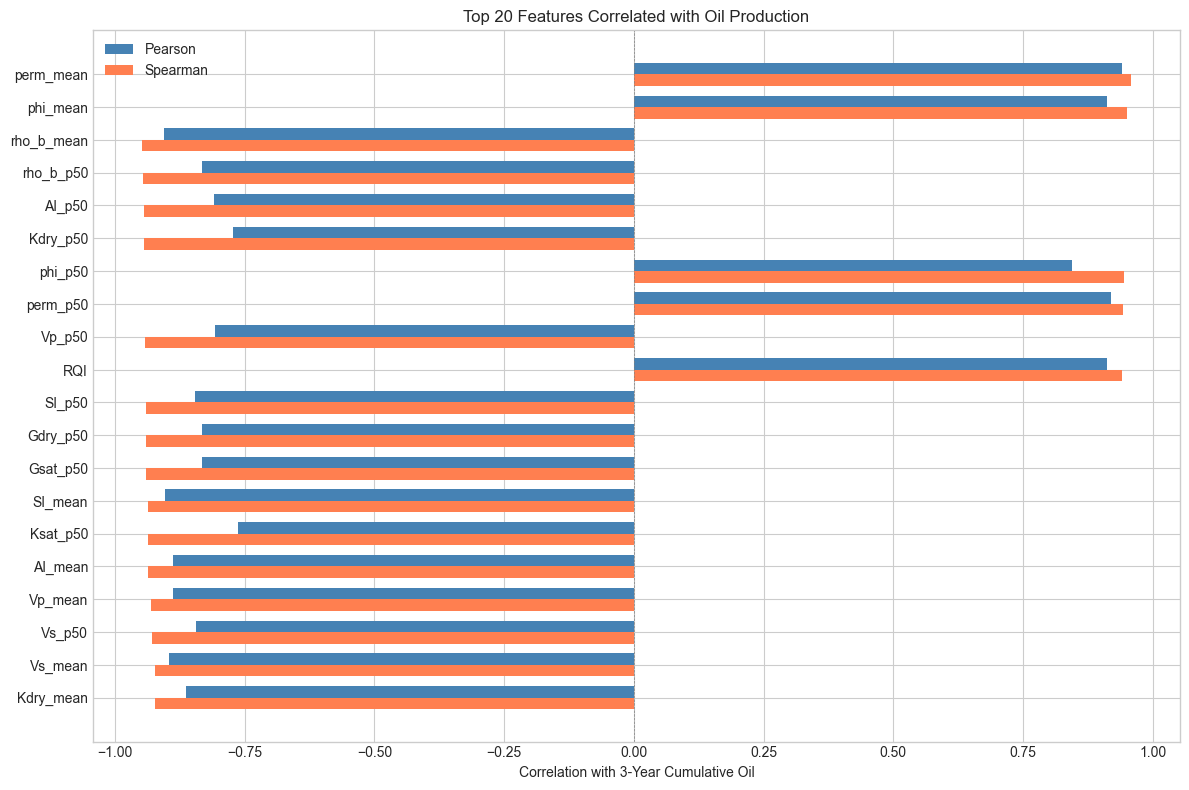

In [19]:
top_n = 20
top_features = correlations.head(top_n)
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(top_n)
width = 0.35
bars1 = ax.barh(x - width/2, top_features['Pearson'], width, label='Pearson', color='steelblue')
bars2 = ax.barh(x + width/2, top_features['Spearman'], width, label='Spearman', color='coral')
ax.set_xlabel('Correlation with 3-Year Cumulative Oil')
ax.set_yticks(x)
ax.set_yticklabels(top_features['Feature'])
ax.invert_yaxis()
ax.legend()
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_title(f'Top {top_n} Features Correlated with Oil Production')
plt.tight_layout()
plt.show()

## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

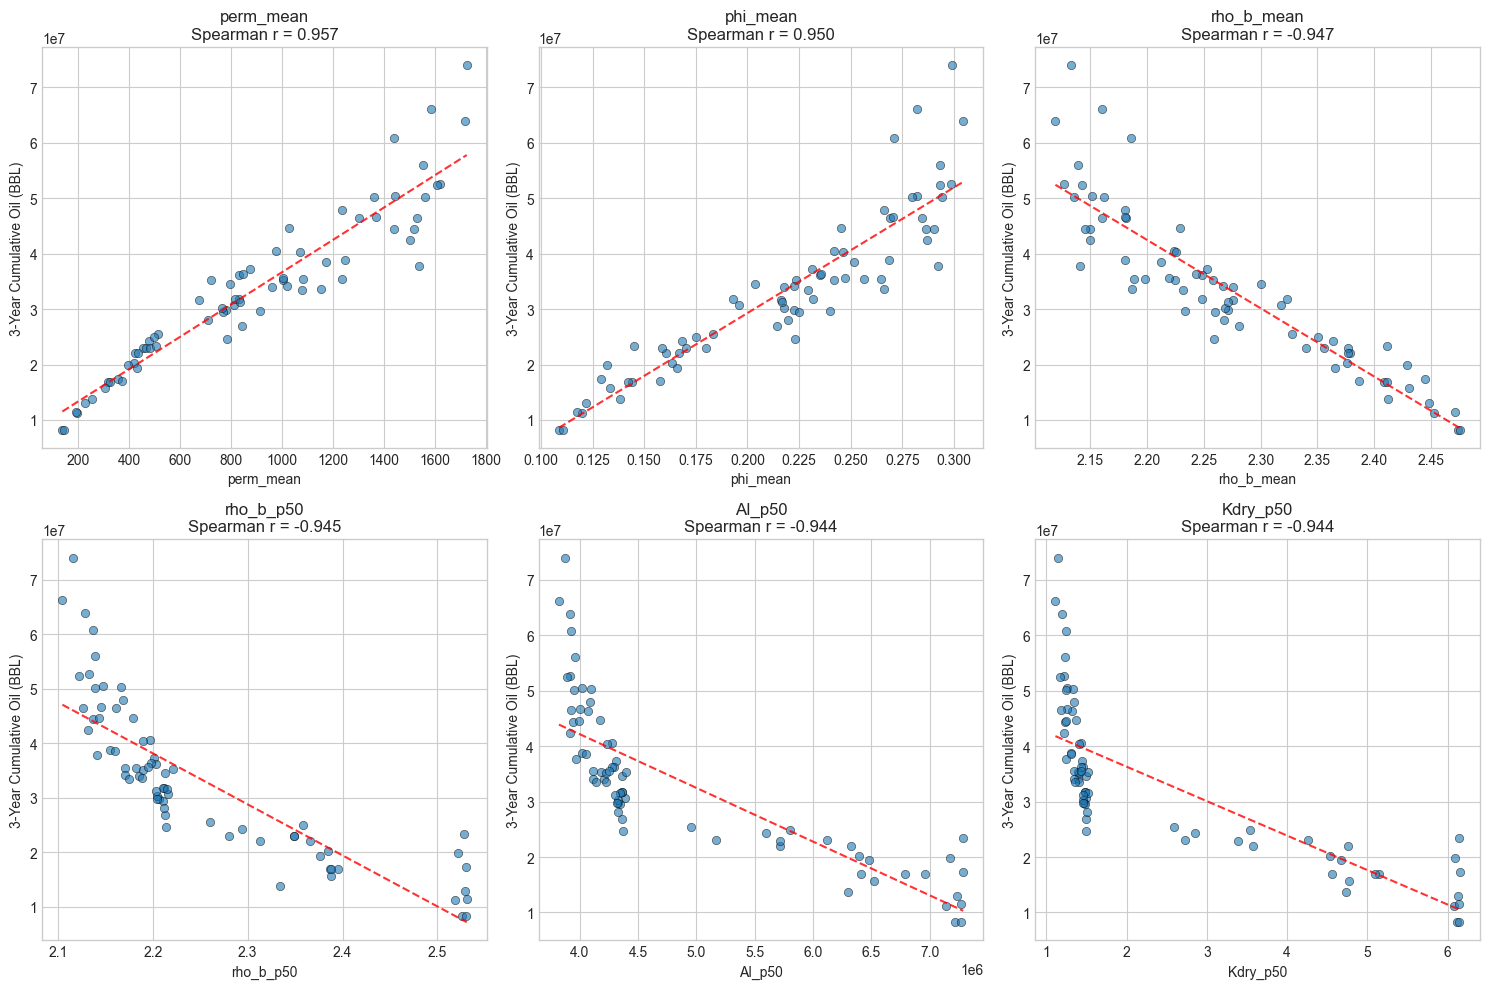

In [20]:
top_6_features = correlations.head(6)['Feature'].tolist()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for idx, feat in enumerate(top_6_features):
    ax = axes[idx]
    ax.scatter(training_data[feat], training_data['Cum_Oil_3yr'], alpha=0.6, edgecolors='k', linewidth=0.5)
    z = np.polyfit(training_data[feat].dropna(), 
                   training_data.loc[training_data[feat].notna(), 'Cum_Oil_3yr'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(training_data[feat].min(), training_data[feat].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.8)
    corr_val = correlations[correlations['Feature'] == feat]['Spearman'].values[0]
    ax.set_title(f'{feat}\nSpearman r = {corr_val:.3f}')
    ax.set_xlabel(feat)
    ax.set_ylabel('3-Year Cumulative Oil (BBL)')
plt.tight_layout()
plt.show()

### Visualizing Data Gaps

A heatmap provides a spatial view of where data is missing. This reveals whether the gaps are random noise or concentrated in specific wells or depth intervals.

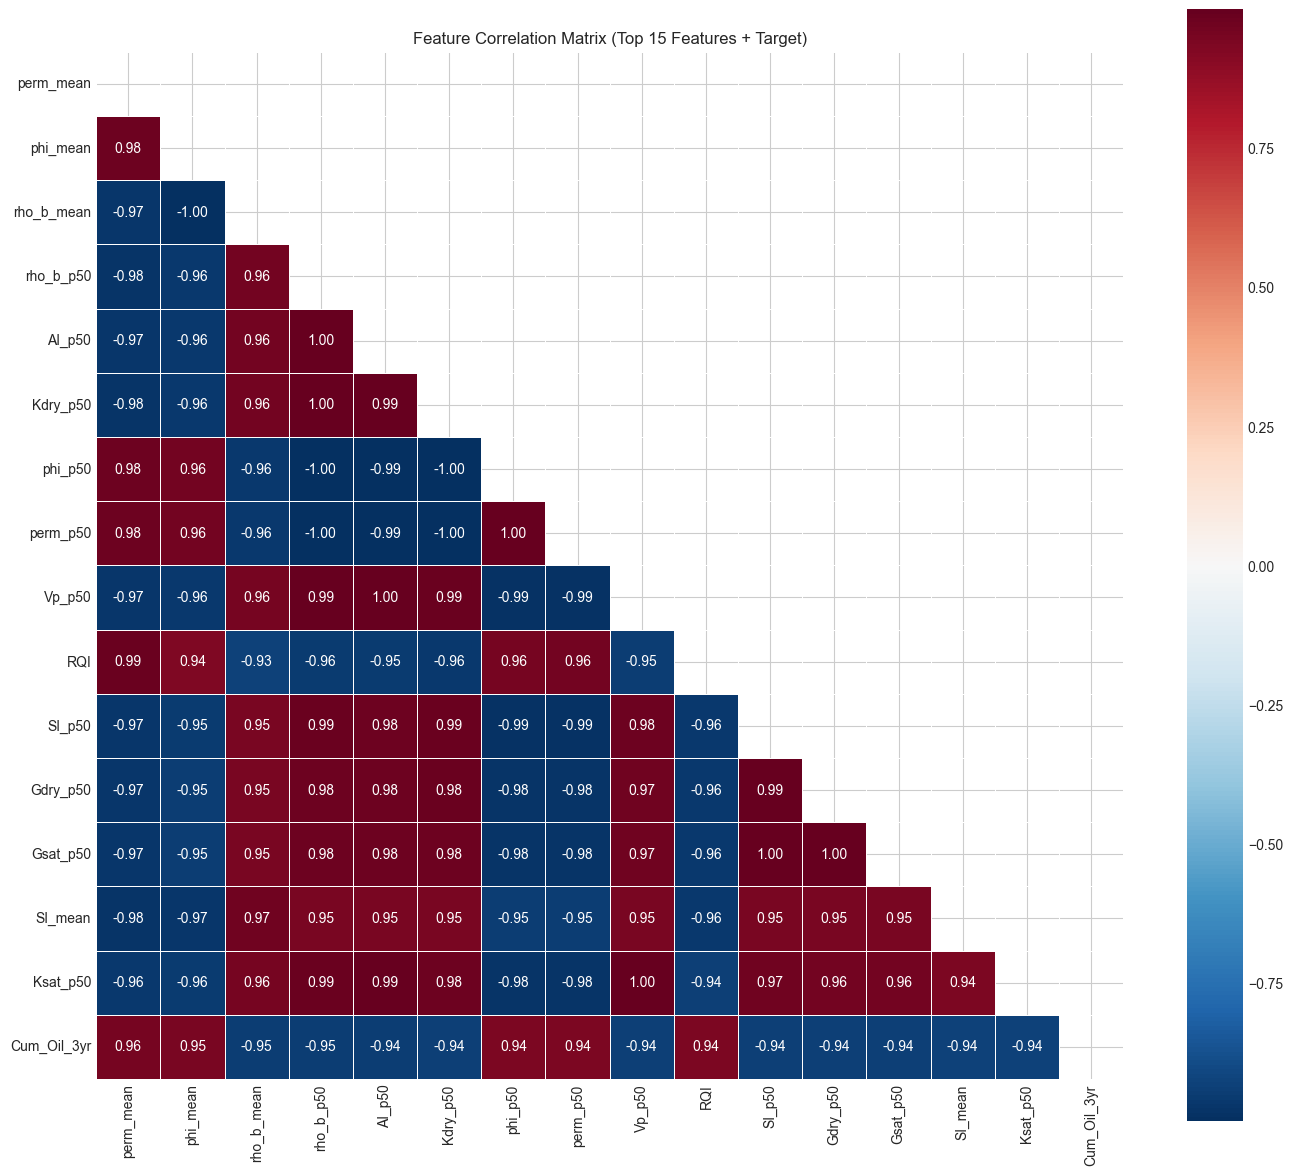

In [21]:
top_features_list = correlations.head(15)['Feature'].tolist()
top_features_list.append('Cum_Oil_3yr')
corr_matrix = training_data[top_features_list].corr(method='spearman')
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix (Top 15 Features + Target)')
plt.tight_layout()
plt.show()

## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

In [22]:
print("=" * 70)
print("EDA SUMMARY - KEY FINDINGS")
print("=" * 70)
print("\n1. DATA OVERVIEW:")
print(f"   - Production wells: {well_logs_prod['Well_ID'].nunique()} (Well IDs 1-71)")
print(f"   - Preproduction wells: {well_logs_preprod['Well_ID'].nunique()} (Well IDs 72-83)")
print(f"   - Depth samples per well: {well_logs_prod.groupby('Well_ID').size().iloc[0]}")
print(f"   - Total features created: {len(feature_cols)}")
print("\n2. MISSING DATA:")
print(f"   - Average missing % per feature: {missing_prod['Missing %'].mean():.2f}%")
print(f"   - Imputation method: Depth-based linear interpolation within wells")
print("\n3. TARGET VARIABLE (3-Year Cumulative Oil):")
print(f"   - Mean: {target_df['Cum_Oil_3yr'].mean():,.0f} BBL")
print(f"   - Std: {target_df['Cum_Oil_3yr'].std():,.0f} BBL")
print(f"   - Range: {target_df['Cum_Oil_3yr'].min():,.0f} - {target_df['Cum_Oil_3yr'].max():,.0f} BBL")
print("\n4. TOP CORRELATED FEATURES (Spearman):")
for i, row in correlations.head(10).iterrows():
    print(f"   {row['Feature']}: r = {row['Spearman']:.3f}")
print("\n5. RECOMMENDED FEATURES FOR MODELING:")
recommended = correlations[correlations['Abs_Spearman'] > 0.3]['Feature'].tolist()
print(f"   Features with |r| > 0.3: {len(recommended)}")
print(f"   {recommended[:10]}..." if len(recommended) > 10 else f"   {recommended}")

EDA SUMMARY - KEY FINDINGS

1. DATA OVERVIEW:
   - Production wells: 71 (Well IDs 1-71)
   - Preproduction wells: 12 (Well IDs 72-83)
   - Depth samples per well: 21
   - Total features created: 131

2. MISSING DATA:
   - Average missing % per feature: 6.10%
   - Imputation method: Depth-based linear interpolation within wells

3. TARGET VARIABLE (3-Year Cumulative Oil):
   - Mean: 33,378,139 BBL
   - Std: 14,148,917 BBL
   - Range: 8,242,955 - 74,021,408 BBL

4. TOP CORRELATED FEATURES (Spearman):
   perm_mean: r = 0.957
   phi_mean: r = 0.950
   rho_b_mean: r = -0.947
   rho_b_p50: r = -0.945
   AI_p50: r = -0.944
   Kdry_p50: r = -0.944
   phi_p50: r = 0.944
   perm_p50: r = 0.943
   Vp_p50: r = -0.942
   RQI: r = 0.941

5. RECOMMENDED FEATURES FOR MODELING:
   Features with |r| > 0.3: 117
   ['perm_mean', 'phi_mean', 'rho_b_mean', 'rho_b_p50', 'AI_p50', 'Kdry_p50', 'phi_p50', 'perm_p50', 'Vp_p50', 'RQI']...


## Submission Generation

The final step involves generating predictions for the test set and formatting them according to competition guidelines. This output file represents the final solution.

In [23]:
training_data.to_csv('training_data_processed.csv', index=False)
features_preprod.to_csv('preproduction_features.csv', index=False)
print("Saved processed data:")
print("  - training_data_processed.csv")
print("  - preproduction_features.csv")

Saved processed data:
  - training_data_processed.csv
  - preproduction_features.csv


## Environment Initialization

Standard data science libraries provide the foundation for matrix manipulation and plotting. Setting display options early ensures that large dataframes remain readable during inspection.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import BaggingRegressor
try:
    import xgboost as xgb
    HAS_XGB = True
    print("XGBoost available")
except ImportError:
    HAS_XGB = False
    print("XGBoost not available - using sklearn alternatives")
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("Libraries loaded successfully!")

XGBoost available
Libraries loaded successfully!


## Data Ingestion

The project data resides in multiple CSV files: well logs (sensor readings), production history (target variables), and a sand proportion map (spatial context). Loading these into memory creates the raw materials for analysis.

In [25]:
well_logs_prod = pd.read_csv('Well_log_data_production_wells.csv')
well_logs_preprod = pd.read_csv('Well_log_data_preproduction_wells.csv')
production_history = pd.read_csv('Production_history_production_wells.csv')
sand_proportion = np.load('2d_sand_proportion.npy')
print(f"Production logs: {well_logs_prod.shape}")
print(f"Preproduction logs: {well_logs_preprod.shape}")
print(f"Production history: {production_history.shape}")

Production logs: (1491, 22)
Preproduction logs: (252, 22)
Production history: (5517, 5)


## Imputation Strategy

Instead of discarding incomplete data, missing values are filled using localized trends. Interpolation works well for continuous curves, while categorical rock types are filled using the most frequent local value.

In [26]:
def impute_well_logs(df):
    """Impute missing values using depth-based interpolation within each well."""
    df_clean = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ['Well_ID', 'X', 'Y', 'Z']]
    for col in numeric_cols:
        if col == 'facies':
            df_clean[col] = df.groupby('Well_ID')[col].transform(
                lambda x: x.ffill().bfill().fillna(
                    x.mode().iloc[0] if len(x.mode()) > 0 else 3)
            )
        else:
            df_clean[col] = df.groupby('Well_ID')[col].transform(
                lambda x: x.interpolate(method='linear').bfill().ffill()
            )
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            df_clean[col] = df_clean[col].fillna(df[col].median())
    return df_clean
def aggregate_well_logs(df):
    """Aggregate depth-indexed well logs to well-level features."""
    def p10(x): return x.quantile(0.1)
    def p50(x): return x.quantile(0.5)
    def p90(x): return x.quantile(0.9)
    log_features = [col for col in df.columns if col not in ['Well_ID', 'X', 'Y', 'Z']]
    agg_dict = {}
    for feat in log_features:
        agg_dict[feat] = ['mean', 'std', 'min', 'max', p10, p50, p90]
    agg_dict['X'] = 'first'
    agg_dict['Y'] = 'first'
    df_agg = df.groupby('Well_ID').agg(agg_dict)
    df_agg.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] 
                      for col in df_agg.columns.values]
    return df_agg.reset_index()
def add_reservoir_features(df):
    """Add domain-specific derived features."""
    df = df.copy()
    if 'perm_mean' in df.columns and 'perm_std' in df.columns:
        df['perm_cv'] = df['perm_std'] / (df['perm_mean'] + 1e-6)
    if 'phi_mean' in df.columns and 'phi_std' in df.columns:
        df['phi_cv'] = df['phi_std'] / (df['phi_mean'] + 1e-6)
    if 'perm_mean' in df.columns and 'phi_mean' in df.columns:
        df['RQI'] = 0.0314 * np.sqrt(df['perm_mean'] / (df['phi_mean'] + 1e-6))
    if 'perm_p90' in df.columns and 'perm_p10' in df.columns:
        df['perm_range_ratio'] = df['perm_p90'] / (df['perm_p10'] + 1e-6)
    return df
def extract_sand_proportion(df, sand_map):
    """Extract sand proportion at each well location."""
    df = df.copy()
    sand_values = []
    map_h, map_w = sand_map.shape
    for _, row in df.iterrows():
        x = min(max(int(row['X']), 0), map_h - 1)
        y = min(max(int(row['Y']), 0), map_w - 1)
        sand_values.append(sand_map[x, y])
    df['sand_proportion'] = sand_values
    return df
def calculate_3yr_cumulative_oil(production_df):
    """Calculate 3-year cumulative oil for each well."""
    production_df = production_df.copy()
    production_df['Date'] = pd.to_datetime(production_df['Date'])
    results = []
    for well_id in production_df['Well_ID'].unique():
        well_data = production_df[production_df['Well_ID'] == well_id].sort_values('Date')
        start_date = well_data['Date'].min()
        end_date_3yr = start_date + pd.DateOffset(years=3)
        well_3yr = well_data[well_data['Date'] <= end_date_3yr]
        if len(well_3yr) > 0:
            cum_oil_3yr = well_3yr['Cumulative Oil Production, BBL'].iloc[-1]
        else:
            cum_oil_3yr = np.nan
        results.append({'Well_ID': well_id, 'Cum_Oil_3yr': cum_oil_3yr})
    return pd.DataFrame(results)
print("Processing functions defined.")

Processing functions defined.


## Imputation Strategy

Instead of discarding incomplete data, missing values are filled using localized trends. Interpolation works well for continuous curves, while categorical rock types are filled using the most frequent local value.

In [27]:
print("Step 1: Imputing missing values...")
well_logs_prod_clean = impute_well_logs(well_logs_prod)
well_logs_preprod_clean = impute_well_logs(well_logs_preprod)
print("Step 2: Aggregating to well-level features...")
features_prod = aggregate_well_logs(well_logs_prod_clean)
features_preprod = aggregate_well_logs(well_logs_preprod_clean)
print("Step 3: Adding derived features...")
features_prod = add_reservoir_features(features_prod)
features_preprod = add_reservoir_features(features_preprod)
print("Step 4: Extracting sand proportion from seismic...")
features_prod = extract_sand_proportion(features_prod, sand_proportion)
features_preprod = extract_sand_proportion(features_preprod, sand_proportion)
print("Step 5: Calculating target variable...")
target_df = calculate_3yr_cumulative_oil(production_history)
print("Step 6: Merging features with target...")
training_data = features_prod.merge(target_df, on='Well_ID', how='left')
print(f"\nTraining data shape: {training_data.shape}")
print(f"Preproduction data shape: {features_preprod.shape}")
print(f"Target variable range: {training_data['Cum_Oil_3yr'].min():,.0f} - {training_data['Cum_Oil_3yr'].max():,.0f} BBL")

Step 1: Imputing missing values...
Step 2: Aggregating to well-level features...
Step 3: Adding derived features...
Step 4: Extracting sand proportion from seismic...
Step 5: Calculating target variable...
Step 6: Merging features with target...

Training data shape: (71, 135)
Preproduction data shape: (12, 134)
Target variable range: 8,242,955 - 74,021,408 BBL


### Handling Missing Values

Filling gaps in the dataset ensures continuity and prevents errors during mathematical operations.

In [28]:
exclude_cols = ['Well_ID', 'X', 'Y', 'Cum_Oil_3yr', 'Start_Date']
feature_cols = [col for col in training_data.columns if col not in exclude_cols]
print(f"Total features available: {len(feature_cols)}")
X = training_data[feature_cols].copy()
y = training_data['Cum_Oil_3yr'].copy()
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

Total features available: 131

Missing values in features: 0
Missing values in target: 0


## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

In [29]:
correlations = X.apply(lambda col: col.corr(y, method='spearman')).abs().sort_values(ascending=False)
print("Top 30 Features by Spearman Correlation:")
print(correlations.head(30))
CORR_THRESHOLD = 0.2
corr_selected_features = correlations[correlations > CORR_THRESHOLD].index.tolist()
print(f"\nFeatures with |r| > {CORR_THRESHOLD}: {len(corr_selected_features)}")

Top 30 Features by Spearman Correlation:
perm_mean     0.957243
phi_mean      0.950402
rho_b_mean    0.947082
rho_b_p50     0.945305
AI_p50        0.944467
Kdry_p50      0.943830
phi_p50       0.943696
perm_p50      0.943494
Vp_p50        0.942455
RQI           0.941180
SI_p50        0.940275
Gdry_p50      0.939705
Gsat_p50      0.939269
SI_mean       0.936117
Ksat_p50      0.935949
AI_mean       0.935882
Vp_mean       0.931120
Vs_p50        0.929510
Vs_mean       0.922602
Kdry_mean     0.922099
Ksat_mean     0.919383
Gsat_mean     0.918947
Gdry_mean     0.918377
perm_cv       0.881824
G0_mean       0.876358
Kdry_p10      0.865493
K0_mean       0.864655
phi_p90       0.860836
GR_mean       0.860765
perm_p90      0.842736
dtype: float64

Features with |r| > 0.2: 122


### Data Structure Preview

A quick look at the first few rows confirms the dataframe is structured correctly and the data types appear as expected.

In [30]:
from sklearn.feature_selection import mutual_info_regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
mi_scores = mutual_info_regression(X_scaled, y, random_state=RANDOM_STATE)
mi_df = pd.DataFrame({'Feature': feature_cols, 'MI_Score': mi_scores}).sort_values('MI_Score', ascending=False)
print("Top 30 Features by Mutual Information:")
print(mi_df.head(30).to_string(index=False))

Top 30 Features by Mutual Information:
    Feature  MI_Score
  perm_mean  1.478057
        RQI  1.168947
   perm_p50  1.163803
    Vp_mean  1.161429
   phi_mean  1.133141
 rho_b_mean  1.119074
    AI_mean  1.094979
    phi_p50  1.093318
  rho_b_p50  1.089607
    SI_mean  1.079325
   Gsat_p50  1.054011
     SI_p50  1.043043
   Gdry_p50  1.026980
     Vp_p50  0.987188
     AI_p50  0.986242
   Ksat_p50  0.938326
  Gsat_mean  0.938207
     Vs_p50  0.936328
   Kdry_p50  0.934888
    Vs_mean  0.928557
  Kdry_mean  0.917241
  Gdry_mean  0.916081
  Ksat_mean  0.898067
    G0_mean  0.827448
facies_mean  0.827201
    GR_mean  0.777477
    K0_mean  0.775117
 rho_f_mean  0.747523
    phi_p90  0.724330
   perm_p90  0.707858


### Feature Importance

Visualizing which features the model relied on most offers interpretability. This confirms whether the model is learning from geological reality or just fitting noise.

In [31]:
rf_selector = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_selector.fit(X_scaled, y)
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf_selector.feature_importances_
}).sort_values('RF_Importance', ascending=False)
print("Top 30 Features by Random Forest Importance:")
print(rf_importance.head(30).to_string(index=False))

Top 30 Features by Random Forest Importance:
   Feature  RF_Importance
rho_b_mean       0.093875
 rho_b_p50       0.093104
 perm_mean       0.084476
    Vs_p50       0.065364
       RQI       0.054528
  phi_mean       0.047869
  Ksat_p50       0.044435
   phi_p50       0.038368
    AI_p50       0.036612
  Kdry_p50       0.028577
    Vp_p50       0.027162
 rho_b_min       0.024393
  Gdry_p50       0.023688
    SI_p50       0.022431
 Kdry_mean       0.021943
  Gsat_p50       0.021206
   AI_mean       0.018118
   Vp_mean       0.017064
  perm_p50       0.015446
    Vs_p10       0.015379
  Gdry_min       0.013428
    G0_min       0.012631
   SI_mean       0.010070
 rho_b_p90       0.009346
 Gsat_mean       0.008931
    GR_p50       0.007420
    Vp_p10       0.007381
   perm_cv       0.007363
 Ksat_mean       0.007248
   Vs_mean       0.006998


## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

In [32]:
TOP_N = 30
corr_top = set(correlations.head(TOP_N).index)
mi_top = set(mi_df.head(TOP_N)['Feature'])
rf_top = set(rf_importance.head(TOP_N)['Feature'])
selected_features = list(
    (corr_top & mi_top) | (corr_top & rf_top) | (mi_top & rf_top)
)
print(f"Features selected by at least 2 methods: {len(selected_features)}")
print(f"\nSelected features: {selected_features}")
if len(selected_features) < 10:
    selected_features = list(corr_top | mi_top | rf_top)
    print(f"\nExpanded to union: {len(selected_features)} features")
elif len(selected_features) > 50:
    selected_features = list(corr_top & mi_top & rf_top)
    if len(selected_features) < 10:
        selected_features = list((corr_top & mi_top) | (corr_top & rf_top) | (mi_top & rf_top))
    print(f"\nReduced to intersection: {len(selected_features)} features")

Features selected by at least 2 methods: 29

Selected features: ['AI_p50', 'perm_p50', 'GR_mean', 'SI_p50', 'AI_mean', 'SI_mean', 'G0_mean', 'Vs_mean', 'Ksat_p50', 'Vp_p50', 'phi_p50', 'perm_p90', 'Ksat_mean', 'K0_mean', 'rho_b_mean', 'phi_p90', 'Gsat_p50', 'Kdry_mean', 'rho_b_p50', 'RQI', 'Vp_mean', 'perm_cv', 'Gsat_mean', 'perm_mean', 'phi_mean', 'Kdry_p50', 'Vs_p50', 'Gdry_p50', 'Gdry_mean']


## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

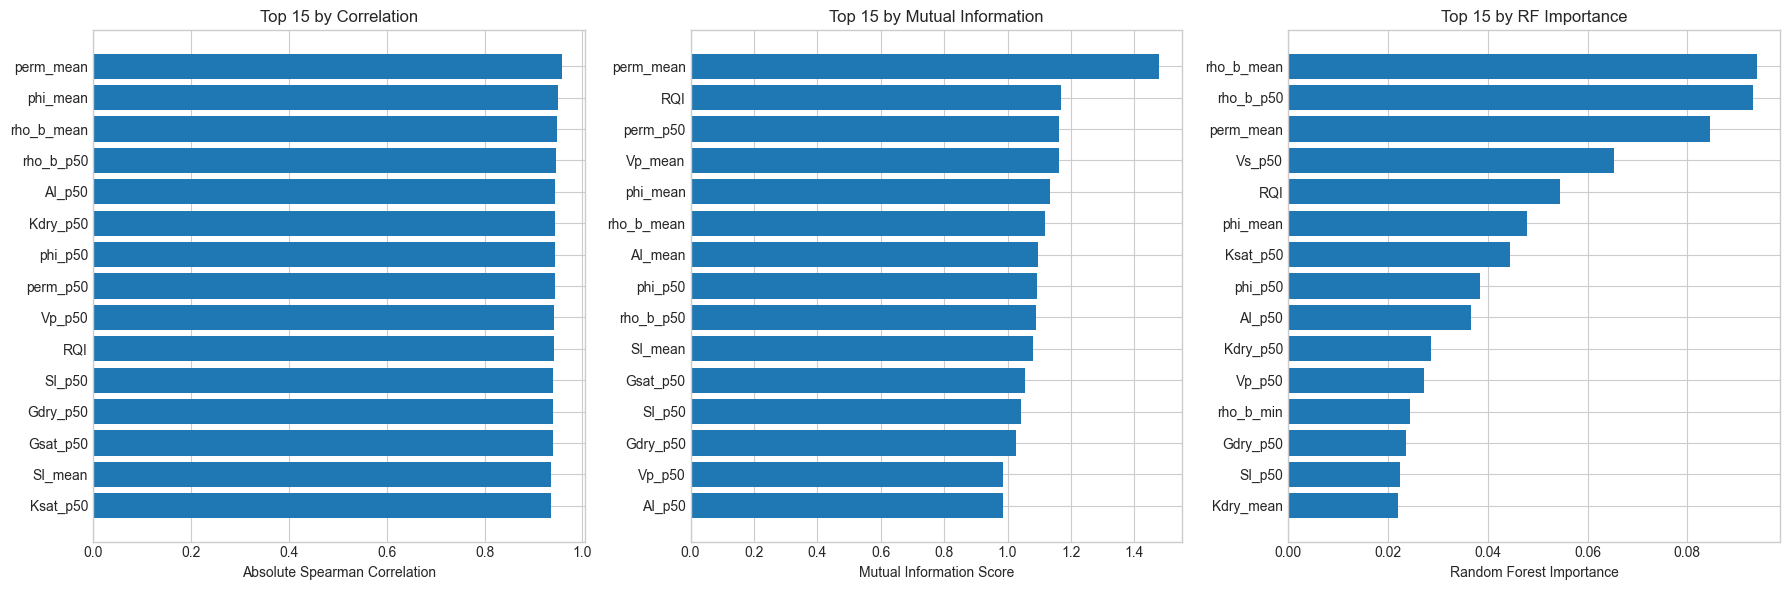

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
top_corr = correlations.head(15)
axes[0].barh(range(len(top_corr)), top_corr.values)
axes[0].set_yticks(range(len(top_corr)))
axes[0].set_yticklabels(top_corr.index)
axes[0].invert_yaxis()
axes[0].set_xlabel('Absolute Spearman Correlation')
axes[0].set_title('Top 15 by Correlation')
top_mi = mi_df.head(15)
axes[1].barh(range(len(top_mi)), top_mi['MI_Score'].values)
axes[1].set_yticks(range(len(top_mi)))
axes[1].set_yticklabels(top_mi['Feature'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Mutual Information Score')
axes[1].set_title('Top 15 by Mutual Information')
top_rf = rf_importance.head(15)
axes[2].barh(range(len(top_rf)), top_rf['RF_Importance'].values)
axes[2].set_yticks(range(len(top_rf)))
axes[2].set_yticklabels(top_rf['Feature'])
axes[2].invert_yaxis()
axes[2].set_xlabel('Random Forest Importance')
axes[2].set_title('Top 15 by RF Importance')
plt.tight_layout()
plt.show()

### Spatial Feature Engineering

Integrating the sand proportion map adds a horizontal dimension to the vertical well data. Smoothing this map and extracting values at well coordinates provides context about the surrounding reservoir quality.

In [34]:
FINAL_FEATURES = selected_features.copy()
key_features = ['phi_mean', 'perm_mean', 'RQI', 'sand_proportion', 'GR_mean', 'facies_mean']
for feat in key_features:
    if feat in feature_cols and feat not in FINAL_FEATURES:
        FINAL_FEATURES.append(feat)
print(f"\nFinal feature set ({len(FINAL_FEATURES)} features):")
for i, f in enumerate(FINAL_FEATURES):
    print(f"  {i+1}. {f}")


Final feature set (31 features):
  1. AI_p50
  2. perm_p50
  3. GR_mean
  4. SI_p50
  5. AI_mean
  6. SI_mean
  7. G0_mean
  8. Vs_mean
  9. Ksat_p50
  10. Vp_p50
  11. phi_p50
  12. perm_p90
  13. Ksat_mean
  14. K0_mean
  15. rho_b_mean
  16. phi_p90
  17. Gsat_p50
  18. Kdry_mean
  19. rho_b_p50
  20. RQI
  21. Vp_mean
  22. perm_cv
  23. Gsat_mean
  24. perm_mean
  25. phi_mean
  26. Kdry_p50
  27. Vs_p50
  28. Gdry_p50
  29. Gdry_mean
  30. sand_proportion
  31. facies_mean


### Handling Missing Values

Filling gaps in the dataset ensures continuity and prevents errors during mathematical operations.

In [35]:
X_train = training_data[FINAL_FEATURES].copy()
y_train = training_data['Cum_Oil_3yr'].copy()
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(X_train.median())
scaler = RobustScaler() 
X_train_scaled = scaler.fit_transform(X_train)
print(f"Training set: {X_train_scaled.shape}")
print(f"Target range: {y_train.min():,.0f} - {y_train.max():,.0f} BBL")

Training set: (71, 31)
Target range: 8,242,955 - 74,021,408 BBL


## Model Training

A Gradient Boosting Regressor fits the training data. This algorithm iteratively corrects its own errors, learning non-linear relationships between the geological features and oil production.

In [36]:
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'SVR': SVR(kernel='rbf', C=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=10, 
                                          min_samples_split=5, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, max_depth=5,
                                                   learning_rate=0.1, random_state=RANDOM_STATE),
}
if HAS_XGB:
    models['XGBoost'] = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1,
                                          random_state=RANDOM_STATE, verbosity=0)
print(f"Evaluating {len(models)} models...")

Evaluating 7 models...


### Performance Metrics

Quantifying error using RMSE (Root Mean Squared Error) and R² provides a concrete measure of accuracy. These metrics reveal how close the predictions are to the actual production figures.

In [37]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    cv_predictions = cross_val_predict(model, X_train_scaled, y_train, cv=cv)
    rmse = np.sqrt(mean_squared_error(y_train, cv_predictions))
    mae = mean_absolute_error(y_train, cv_predictions)
    r2 = r2_score(y_train, cv_predictions)
    mape = np.mean(np.abs((y_train - cv_predictions) / y_train)) * 100
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    })
    print(f"  RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | R²: {r2:.3f} | MAPE: {mape:.1f}%")
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\n" + "="*60)
print("MODEL COMPARISON (sorted by RMSE):")
print("="*60)
print(results_df.to_string(index=False))


Evaluating Ridge...
  RMSE: 5,213,896 | MAE: 3,882,375 | R²: 0.862 | MAPE: 11.4%

Evaluating Lasso...
  RMSE: 6,146,576 | MAE: 4,897,663 | R²: 0.809 | MAPE: 17.9%

Evaluating ElasticNet...
  RMSE: 6,110,517 | MAE: 4,178,535 | R²: 0.811 | MAPE: 12.2%

Evaluating SVR...
  RMSE: 14,412,866 | MAE: 11,358,961 | R²: -0.052 | MAPE: 47.0%

Evaluating RandomForest...
  RMSE: 5,418,089 | MAE: 3,908,502 | R²: 0.851 | MAPE: 11.5%

Evaluating GradientBoosting...
  RMSE: 5,376,241 | MAE: 3,893,448 | R²: 0.854 | MAPE: 10.9%

Evaluating XGBoost...
  RMSE: 5,477,680 | MAE: 4,060,481 | R²: 0.848 | MAPE: 11.5%

MODEL COMPARISON (sorted by RMSE):
           Model         RMSE          MAE        R2      MAPE
           Ridge 5.213896e+06 3.882375e+06  0.862267 11.411583
GradientBoosting 5.376241e+06 3.893448e+06  0.853556 10.949277
    RandomForest 5.418089e+06 3.908502e+06  0.851267 11.507178
         XGBoost 5.477680e+06 4.060481e+06  0.847978 11.466571
      ElasticNet 6.110517e+06 4.178535e+06  0.810

### Data Visualization

Visual inspection of the data distribution highlights patterns and potential outliers that raw statistics might miss.

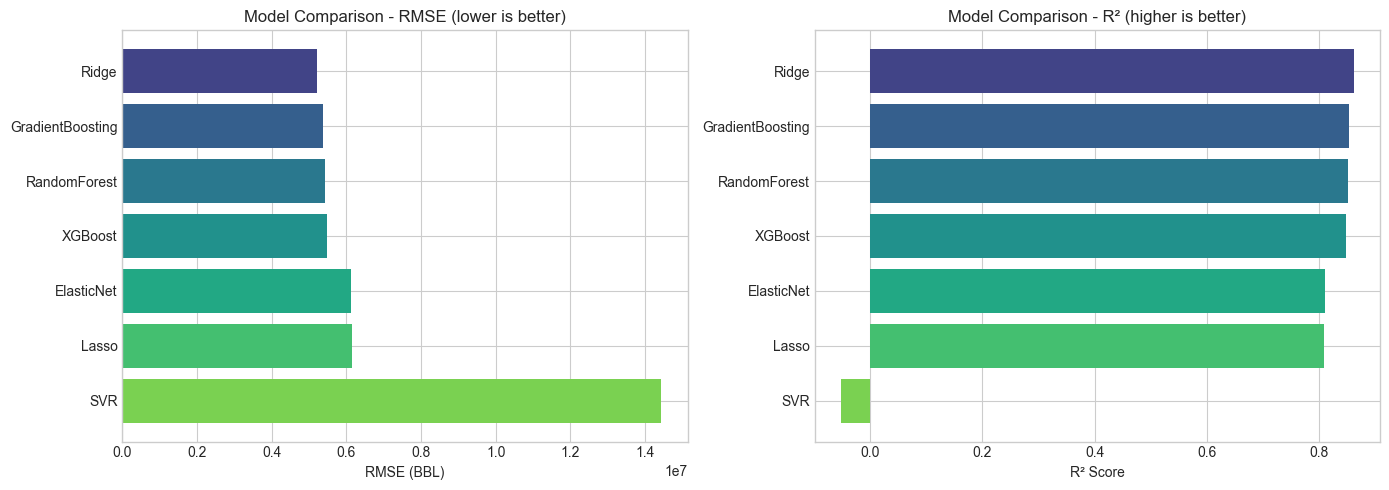

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(results_df)))
axes[0].barh(results_df['Model'], results_df['RMSE'], color=colors)
axes[0].set_xlabel('RMSE (BBL)')
axes[0].set_title('Model Comparison - RMSE (lower is better)')
axes[0].invert_yaxis()
axes[1].barh(results_df['Model'], results_df['R2'], color=colors)
axes[1].set_xlabel('R² Score')
axes[1].set_title('Model Comparison - R² (higher is better)')
axes[1].invert_yaxis()
plt.tight_layout()
plt.show()

### Data Visualization

Visual inspection of the data distribution highlights patterns and potential outliers that raw statistics might miss.

Best model: Ridge


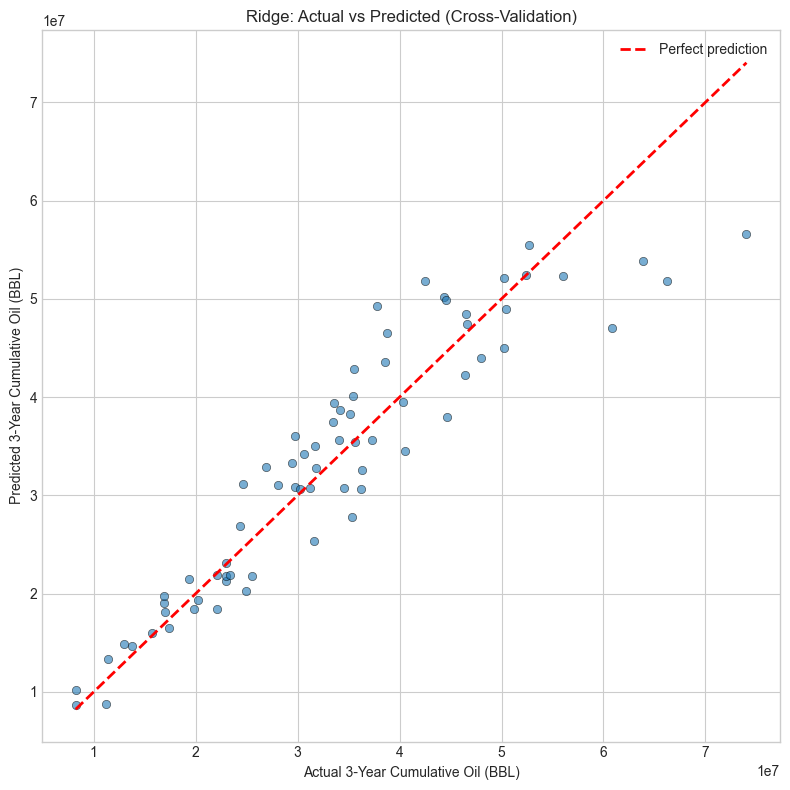

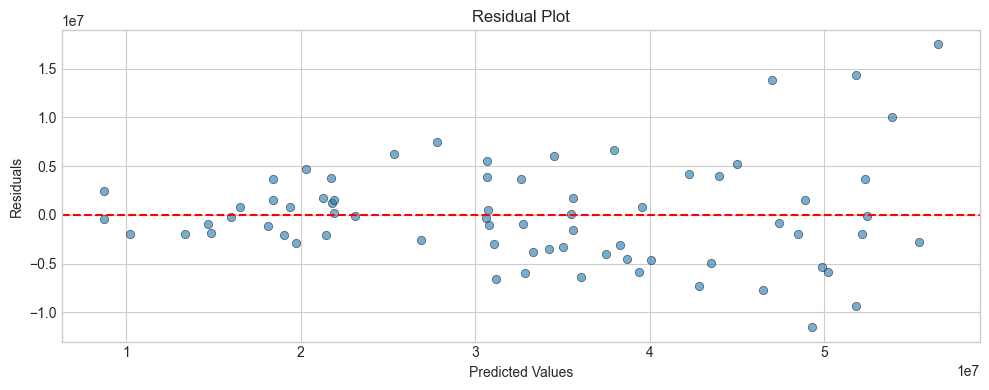

In [39]:
BEST_MODEL_NAME = results_df.iloc[0]['Model']
print(f"Best model: {BEST_MODEL_NAME}")
best_model = models[BEST_MODEL_NAME]
best_model.fit(X_train_scaled, y_train)
cv_preds = cross_val_predict(best_model, X_train_scaled, y_train, cv=cv)
plt.figure(figsize=(8, 8))
plt.scatter(y_train, cv_preds, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual 3-Year Cumulative Oil (BBL)')
plt.ylabel('Predicted 3-Year Cumulative Oil (BBL)')
plt.title(f'{BEST_MODEL_NAME}: Actual vs Predicted (Cross-Validation)')
plt.legend()
plt.tight_layout()
plt.show()
residuals = y_train - cv_preds
plt.figure(figsize=(10, 4))
plt.scatter(cv_preds, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

## Model Training

A Gradient Boosting Regressor fits the training data. This algorithm iteratively corrects its own errors, learning non-linear relationships between the geological features and oil production.

In [40]:
N_REALIZATIONS = 100
print(f"Training {N_REALIZATIONS} models for uncertainty quantification...")
if BEST_MODEL_NAME == 'RandomForest':
    base_model = RandomForestRegressor(n_estimators=50, max_depth=10, 
                                        min_samples_split=5, random_state=RANDOM_STATE)
elif BEST_MODEL_NAME == 'GradientBoosting':
    base_model = GradientBoostingRegressor(n_estimators=100, max_depth=5,
                                            learning_rate=0.1, random_state=RANDOM_STATE)
elif HAS_XGB and BEST_MODEL_NAME == 'XGBoost':
    base_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                                   random_state=RANDOM_STATE, verbosity=0)
else:
    base_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RANDOM_STATE)
ensemble_models = []
for i in range(N_REALIZATIONS):
    if (i + 1) % 20 == 0:
        print(f"  Training model {i+1}/{N_REALIZATIONS}...")
    np.random.seed(RANDOM_STATE + i)
    indices = np.random.choice(len(X_train_scaled), size=len(X_train_scaled), replace=True)
    X_boot = X_train_scaled[indices]
    y_boot = y_train.iloc[indices].values
    model = RandomForestRegressor(n_estimators=100, max_depth=10, 
                                   min_samples_split=5, random_state=RANDOM_STATE + i)
    model.fit(X_boot, y_boot)
    ensemble_models.append(model)
print(f"\nTrained {len(ensemble_models)} models for uncertainty estimation.")

Training 100 models for uncertainty quantification...
  Training model 20/100...
  Training model 40/100...
  Training model 60/100...
  Training model 80/100...
  Training model 100/100...

Trained 100 models for uncertainty estimation.


### Calculation Logic

This block executes a specific mathematical transformation required to prepare the data for the next stage.

In [41]:
cv_residuals = y_train.values - cv_preds
residual_std = np.std(cv_residuals)
print(f"Cross-validation residual standard deviation: {residual_std:,.0f} BBL")
print(f"This will be used to add Gaussian noise to realizations if needed.")

Cross-validation residual standard deviation: 5,213,752 BBL
This will be used to add Gaussian noise to realizations if needed.


### Handling Missing Values

Filling gaps in the dataset ensures continuity and prevents errors during mathematical operations.

In [42]:
X_preprod = features_preprod[FINAL_FEATURES].copy()
X_preprod = X_preprod.replace([np.inf, -np.inf], np.nan)
for col in X_preprod.columns:
    if X_preprod[col].isnull().any():
        X_preprod[col].fillna(X_train[col].median(), inplace=True)
X_preprod_scaled = scaler.transform(X_preprod)
print(f"Preproduction wells: {len(X_preprod)}")
print(f"Well IDs: {features_preprod['Well_ID'].values}")

Preproduction wells: 12
Well IDs: [72 73 74 75 76 77 78 79 80 81 82 83]


### Inference

The trained model applies its learned logic to new data to generate predictions.

In [43]:
predictions_matrix = np.zeros((len(X_preprod), N_REALIZATIONS))
print(f"Generating {N_REALIZATIONS} realizations for {len(X_preprod)} wells...")
for i, model in enumerate(ensemble_models):
    predictions_matrix[:, i] = model.predict(X_preprod_scaled)
predictions_matrix = np.maximum(predictions_matrix, 0)
print(f"\nPrediction matrix shape: {predictions_matrix.shape}")
print(f"(rows = wells, columns = realizations)")

Generating 100 realizations for 12 wells...

Prediction matrix shape: (12, 100)
(rows = wells, columns = realizations)


### Calculation Logic

This block executes a specific mathematical transformation required to prepare the data for the next stage.

In [44]:
well_ids = features_preprod['Well_ID'].values
prediction_summary = pd.DataFrame({
    'Well_ID': well_ids,
    'Estimate': np.mean(predictions_matrix, axis=1),
    'P10': np.percentile(predictions_matrix, 10, axis=1),
    'P50': np.percentile(predictions_matrix, 50, axis=1),
    'P90': np.percentile(predictions_matrix, 90, axis=1),
    'Std': np.std(predictions_matrix, axis=1)
})
print("Prediction Summary for Preproduction Wells:")
print("="*70)
print(prediction_summary.to_string(index=False))

Prediction Summary for Preproduction Wells:
 Well_ID     Estimate          P10          P50          P90          Std
      72 2.884739e+07 2.648142e+07 2.896200e+07 3.091842e+07 1.785543e+06
      73 3.733635e+07 3.540895e+07 3.699743e+07 3.982781e+07 1.787379e+06
      74 3.283282e+07 3.096971e+07 3.289871e+07 3.433815e+07 1.462830e+06
      75 5.241486e+07 4.715288e+07 5.230708e+07 5.761365e+07 4.037266e+06
      76 3.254139e+07 3.075601e+07 3.211396e+07 3.476535e+07 1.556765e+06
      77 2.716404e+07 2.554242e+07 2.722336e+07 2.874639e+07 1.324463e+06
      78 1.080665e+07 9.458034e+06 1.054017e+07 1.217248e+07 1.162126e+06
      79 2.081242e+07 1.992973e+07 2.065285e+07 2.196313e+07 7.919506e+05
      80 1.065237e+07 9.032043e+06 1.049849e+07 1.239912e+07 1.301625e+06
      81 1.751569e+07 1.685861e+07 1.731053e+07 1.833845e+07 7.433567e+05
      82 1.484453e+07 1.361157e+07 1.489970e+07 1.591094e+07 8.987632e+05
      83 2.093904e+07 1.967116e+07 2.106589e+07 2.200283e+07 8.73014

### Data Visualization

Visual inspection of the data distribution highlights patterns and potential outliers that raw statistics might miss.

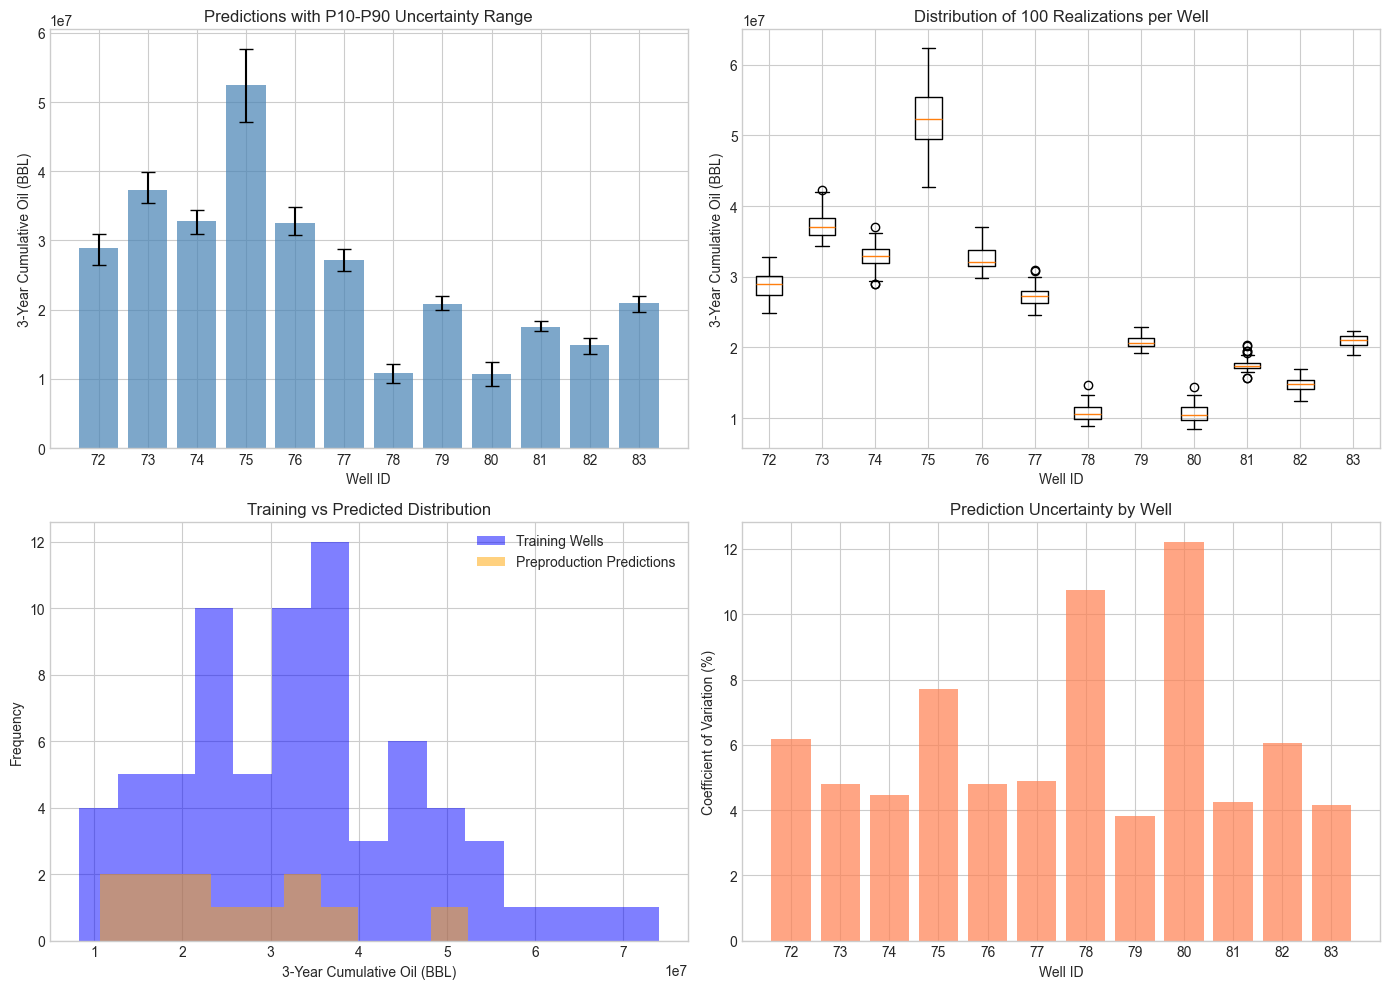

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax = axes[0, 0]
x_pos = np.arange(len(well_ids))
ax.bar(x_pos, prediction_summary['Estimate'], yerr=[prediction_summary['Estimate'] - prediction_summary['P10'],
                                                     prediction_summary['P90'] - prediction_summary['Estimate']],
       capsize=5, alpha=0.7, color='steelblue')
ax.set_xticks(x_pos)
ax.set_xticklabels(well_ids)
ax.set_xlabel('Well ID')
ax.set_ylabel('3-Year Cumulative Oil (BBL)')
ax.set_title('Predictions with P10-P90 Uncertainty Range')
ax = axes[0, 1]
ax.boxplot([predictions_matrix[i, :] for i in range(len(well_ids))], labels=well_ids)
ax.set_xlabel('Well ID')
ax.set_ylabel('3-Year Cumulative Oil (BBL)')
ax.set_title('Distribution of 100 Realizations per Well')
ax = axes[1, 0]
ax.hist(y_train, bins=15, alpha=0.5, label='Training Wells', color='blue')
ax.hist(prediction_summary['Estimate'], bins=10, alpha=0.5, label='Preproduction Predictions', color='orange')
ax.set_xlabel('3-Year Cumulative Oil (BBL)')
ax.set_ylabel('Frequency')
ax.set_title('Training vs Predicted Distribution')
ax.legend()
ax = axes[1, 1]
cv = prediction_summary['Std'] / prediction_summary['Estimate'] * 100
ax.bar(x_pos, cv, alpha=0.7, color='coral')
ax.set_xticks(x_pos)
ax.set_xticklabels(well_ids)
ax.set_xlabel('Well ID')
ax.set_ylabel('Coefficient of Variation (%)')
ax.set_title('Prediction Uncertainty by Well')
plt.tight_layout()
plt.show()

### Data Structure Preview

A quick look at the first few rows confirms the dataframe is structured correctly and the data types appear as expected.

In [46]:
solution = pd.DataFrame()
solution['Well_ID'] = well_ids
solution['Estimate'] = np.mean(predictions_matrix, axis=1)
for i in range(N_REALIZATIONS):
    solution[f'Realization_{i+1}'] = predictions_matrix[:, i]
print(f"Solution shape: {solution.shape}")
print(f"\nColumn names: Well_ID, Estimate, Realization_1 through Realization_100")
print(f"\nPreview:")
print(solution.iloc[:, :6].head()) 


Solution shape: (12, 102)

Column names: Well_ID, Estimate, Realization_1 through Realization_100

Preview:
   Well_ID      Estimate  Realization_1  Realization_2  Realization_3  \
0       72  2.884739e+07   2.738410e+07   2.531699e+07   2.679799e+07   
1       73  3.733635e+07   3.870232e+07   3.704138e+07   3.907343e+07   
2       74  3.283282e+07   3.380121e+07   3.198945e+07   3.345846e+07   
3       75  5.241486e+07   5.596270e+07   5.232155e+07   5.327558e+07   
4       76  3.254139e+07   3.339672e+07   2.977256e+07   3.400106e+07   

   Realization_4  
0   2.769747e+07  
1   3.944660e+07  
2   3.343947e+07  
3   4.807769e+07  
4   3.290715e+07  


## Data Ingestion

The project data resides in multiple CSV files: well logs (sensor readings), production history (target variables), and a sand proportion map (spatial context). Loading these into memory creates the raw materials for analysis.

In [47]:
solution.to_csv('solution.csv', index=False)
print("Saved: solution.csv")
check = pd.read_csv('solution.csv')
print(f"\nVerification:")
print(f"  Shape: {check.shape}")
print(f"  Wells: {check['Well_ID'].tolist()}")
print(f"  Estimate range: {check['Estimate'].min():,.0f} - {check['Estimate'].max():,.0f} BBL")

Saved: solution.csv

Verification:
  Shape: (12, 102)
  Wells: [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
  Estimate range: 10,652,372 - 52,414,861 BBL


### Feature Importance

Visualizing which features the model relied on most offers interpretability. This confirms whether the model is learning from geological reality or just fitting noise.

In [48]:
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': FINAL_FEATURES,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
    plt.xlabel('Feature Importance')
    plt.title(f'{BEST_MODEL_NAME} - Top 20 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))

### Calculation Logic

This block executes a specific mathematical transformation required to prepare the data for the next stage.

In [49]:
print("="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\n1. DATA:")
print(f"   - Training wells: {len(training_data)}")
print(f"   - Preproduction wells: {len(features_preprod)}")
print(f"   - Features used: {len(FINAL_FEATURES)}")
print(f"\n2. MODEL PERFORMANCE (Cross-Validation):")
best_result = results_df.iloc[0]
print(f"   - Best Model: {BEST_MODEL_NAME}")
print(f"   - RMSE: {best_result['RMSE']:,.0f} BBL")
print(f"   - MAE: {best_result['MAE']:,.0f} BBL")
print(f"   - R²: {best_result['R2']:.3f}")
print(f"   - MAPE: {best_result['MAPE']:.1f}%")
print(f"\n3. PREDICTIONS:")
print(f"   - Number of realizations: {N_REALIZATIONS}")
print(f"   - Prediction range: {prediction_summary['Estimate'].min():,.0f} - {prediction_summary['Estimate'].max():,.0f} BBL")
print(f"   - Average uncertainty (P90-P10): {(prediction_summary['P90'] - prediction_summary['P10']).mean():,.0f} BBL")
print(f"\n4. OUTPUT FILES:")
print(f"   - solution.csv (Finished outputting!)")
print("\n" + "="*70)
print("="*70)

FINAL SUMMARY

1. DATA:
   - Training wells: 71
   - Preproduction wells: 12
   - Features used: 31

2. MODEL PERFORMANCE (Cross-Validation):
   - Best Model: Ridge
   - RMSE: 5,213,896 BBL
   - MAE: 3,882,375 BBL
   - R²: 0.862
   - MAPE: 11.4%

3. PREDICTIONS:
   - Number of realizations: 100
   - Prediction range: 10,652,372 - 52,414,861 BBL
   - Average uncertainty (P90-P10): 3,677,014 BBL

4. OUTPUT FILES:
   - solution.csv (Finished outputting!)



## Environment Initialization

Standard data science libraries provide the foundation for matrix manipulation and plotting. Setting display options early ensures that large dataframes remain readable during inspection.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter, median_filter
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
START_DATE = pd.Timestamp('2022-12-01')
END_DATE = pd.Timestamp('2025-12-01')
print("Libraries loaded!")
print(f"Target Period: {START_DATE.strftime('%b %d, %Y')} to {END_DATE.strftime('%b %d, %Y')}")

Libraries loaded!
Target Period: Dec 01, 2022 to Dec 01, 2025


## Data Ingestion

The project data resides in multiple CSV files: well logs (sensor readings), production history (target variables), and a sand proportion map (spatial context). Loading these into memory creates the raw materials for analysis.

In [51]:
well_logs_prod = pd.read_csv('Well_log_data_production_wells.csv')
well_logs_preprod = pd.read_csv('Well_log_data_preproduction_wells.csv')
production_history = pd.read_csv('Production_history_production_wells.csv')
sand_proportion_raw = np.load('2d_sand_proportion.npy')
production_history['Date'] = pd.to_datetime(production_history['Date'])
print(f"Well logs (production): {well_logs_prod.shape}")
print(f"Well logs (preproduction): {well_logs_preprod.shape}")
print(f"Production history: {production_history.shape}")
print(f"\n{'='*60}")
print("RAW SAND PROPORTION MAP")
print(f"{'='*60}")
print(f"Shape: {sand_proportion_raw.shape}")
print(f"Range: [{sand_proportion_raw.min():.4f}, {sand_proportion_raw.max():.4f}]")
print(f"Mean: {sand_proportion_raw.mean():.4f}, Std: {sand_proportion_raw.std():.4f}")
print(f"\nWell X range: [{well_logs_prod['X'].min()}, {well_logs_prod['X'].max()}]")
print(f"Well Y range: [{well_logs_prod['Y'].min()}, {well_logs_prod['Y'].max()}]")

Well logs (production): (1491, 22)
Well logs (preproduction): (252, 22)
Production history: (5517, 5)

RAW SAND PROPORTION MAP
Shape: (200, 200)
Range: [0.6222, 0.6253]
Mean: 0.6237, Std: 0.0004

Well X range: [21, 197]
Well Y range: [20, 192]


### Spatial Feature Engineering

Integrating the sand proportion map adds a horizontal dimension to the vertical well data. Smoothing this map and extracting values at well coordinates provides context about the surrounding reservoir quality.

In [52]:
sand_normalized = (sand_proportion_raw - sand_proportion_raw.min()) / (sand_proportion_raw.max() - sand_proportion_raw.min())
sand_gaussian = gaussian_filter(sand_normalized, sigma=1.0)
sand_median = median_filter(sand_normalized, size=3)
sand_denoised = gaussian_filter(median_filter(sand_normalized, size=3), sigma=0.5)
print("DENOISING COMPARISON:")
print(f"{'Method':<20} {'Min':<10} {'Max':<10} {'Mean':<10} {'Std':<10}")
print("-"*60)
print(f"{'Raw Normalized':<20} {sand_normalized.min():<10.4f} {sand_normalized.max():<10.4f} {sand_normalized.mean():<10.4f} {sand_normalized.std():<10.4f}")
print(f"{'Gaussian (σ=1)':<20} {sand_gaussian.min():<10.4f} {sand_gaussian.max():<10.4f} {sand_gaussian.mean():<10.4f} {sand_gaussian.std():<10.4f}")
print(f"{'Median (3x3)':<20} {sand_median.min():<10.4f} {sand_median.max():<10.4f} {sand_median.mean():<10.4f} {sand_median.std():<10.4f}")
print(f"{'Combined':<20} {sand_denoised.min():<10.4f} {sand_denoised.max():<10.4f} {sand_denoised.mean():<10.4f} {sand_denoised.std():<10.4f}")
sand_proportion = sand_denoised
print(f"\n→ Using COMBINED denoised map for feature extraction.")

DENOISING COMPARISON:
Method               Min        Max        Mean       Std       
------------------------------------------------------------
Raw Normalized       0.0000     1.0000     0.4979     0.1292    
Gaussian (σ=1)       0.2740     0.7848     0.4979     0.0885    
Median (3x3)         0.2229     0.8192     0.4981     0.0929    
Combined             0.2511     0.7935     0.4981     0.0904    

→ Using COMBINED denoised map for feature extraction.


### Data Visualization

Visual inspection of the data distribution highlights patterns and potential outliers that raw statistics might miss.

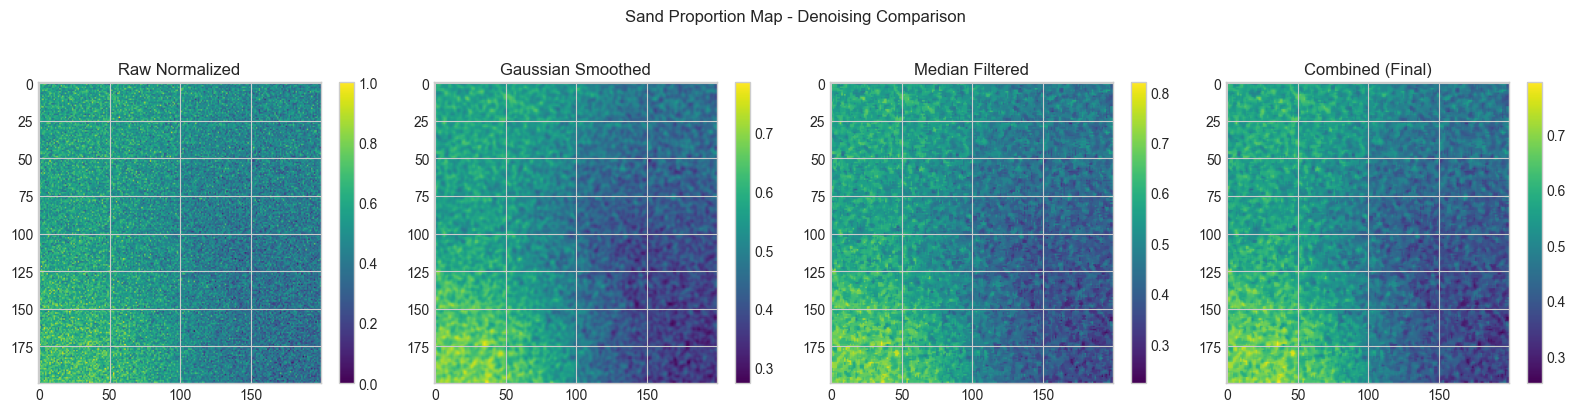

In [53]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
im0 = axes[0].imshow(sand_normalized, cmap='viridis', aspect='auto')
axes[0].set_title('Raw Normalized')
plt.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(sand_gaussian, cmap='viridis', aspect='auto')
axes[1].set_title('Gaussian Smoothed')
plt.colorbar(im1, ax=axes[1])
im2 = axes[2].imshow(sand_median, cmap='viridis', aspect='auto')
axes[2].set_title('Median Filtered')
plt.colorbar(im2, ax=axes[2])
im3 = axes[3].imshow(sand_denoised, cmap='viridis', aspect='auto')
axes[3].set_title('Combined (Final)')
plt.colorbar(im3, ax=axes[3])
plt.suptitle('Sand Proportion Map - Denoising Comparison', y=1.02)
plt.tight_layout()
plt.show()

## Imputation Strategy

Instead of discarding incomplete data, missing values are filled using localized trends. Interpolation works well for continuous curves, while categorical rock types are filled using the most frequent local value.

In [54]:
def impute_well_logs(df):
    """Impute missing values using depth-based interpolation."""
    df_clean = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ['Well_ID', 'X', 'Y', 'Z']]
    for col in numeric_cols:
        if col == 'facies':
            df_clean[col] = df.groupby('Well_ID')[col].transform(
                lambda x: x.ffill().bfill().fillna(
                    x.mode().iloc[0] if len(x.mode()) > 0 else 3)
            )
        else:
            df_clean[col] = df.groupby('Well_ID')[col].transform(
                lambda x: x.interpolate(method='linear').bfill().ffill()
            )
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            df_clean[col] = df_clean[col].fillna(df[col].median())
    return df_clean
def aggregate_well_logs(df):
    """Aggregate depth-indexed logs to well-level features."""
    def p10(x): return x.quantile(0.1)
    def p50(x): return x.quantile(0.5)
    def p90(x): return x.quantile(0.9)
    log_features = [col for col in df.columns if col not in ['Well_ID', 'X', 'Y', 'Z']]
    agg_dict = {}
    for feat in log_features:
        agg_dict[feat] = ['mean', 'std', 'min', 'max', p10, p50, p90]
    agg_dict['X'] = 'first'
    agg_dict['Y'] = 'first'
    df_agg = df.groupby('Well_ID').agg(agg_dict)
    df_agg.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] 
                      for col in df_agg.columns.values]
    return df_agg.reset_index()
def add_reservoir_features(df):
    """Add derived reservoir features."""
    df = df.copy()
    if 'perm_mean' in df.columns and 'perm_std' in df.columns:
        df['perm_cv'] = df['perm_std'] / (df['perm_mean'] + 1e-6)
    if 'phi_mean' in df.columns and 'phi_std' in df.columns:
        df['phi_cv'] = df['phi_std'] / (df['phi_mean'] + 1e-6)
    if 'perm_mean' in df.columns and 'phi_mean' in df.columns:
        df['RQI'] = 0.0314 * np.sqrt(df['perm_mean'] / (df['phi_mean'] + 1e-6))
    if 'perm_p90' in df.columns and 'perm_p10' in df.columns:
        df['perm_range_ratio'] = df['perm_p90'] / (df['perm_p10'] + 1e-6)
    return df
def extract_sand_features(df, sand_map):
    """Extract multiple sand proportion features at well locations."""
    df = df.copy()
    sand_point = []
    sand_local_mean = []
    sand_local_std = []
    for _, row in df.iterrows():
        x = int(row['X'])
        y = int(row['Y'])
        x = min(max(x, 1), sand_map.shape[0] - 2)
        y = min(max(y, 1), sand_map.shape[1] - 2)
        sand_point.append(sand_map[x, y])
        neighborhood = sand_map[x-1:x+2, y-1:y+2]
        sand_local_mean.append(np.mean(neighborhood))
        sand_local_std.append(np.std(neighborhood))
    df['sand_proportion'] = sand_point
    df['sand_local_mean'] = sand_local_mean
    df['sand_local_std'] = sand_local_std
    return df
def calculate_target_fixed_period(production_df, start_date, end_date):
    """Calculate cumulative oil for Dec 1, 2022 - Dec 1, 2025."""
    results = []
    for well_id in production_df['Well_ID'].unique():
        well_data = production_df[production_df['Well_ID'] == well_id].sort_values('Date')
        data_at_start = well_data[well_data['Date'] <= start_date]
        cum_oil_start = data_at_start.iloc[-1]['Cumulative Oil Production, BBL'] if len(data_at_start) > 0 else 0
        data_at_end = well_data[well_data['Date'] <= end_date]
        cum_oil_end = data_at_end.iloc[-1]['Cumulative Oil Production, BBL'] if len(data_at_end) > 0 else np.nan
        cum_oil_3yr = cum_oil_end - cum_oil_start if not np.isnan(cum_oil_end) else np.nan
        results.append({'Well_ID': well_id, 'Cum_Oil_3yr': cum_oil_3yr})
    return pd.DataFrame(results)
print("Functions defined!")

Functions defined!


## Imputation Strategy

Instead of discarding incomplete data, missing values are filled using localized trends. Interpolation works well for continuous curves, while categorical rock types are filled using the most frequent local value.

In [55]:
START_DATE = '2022-12-01'
END_DATE = '2025-12-01'
print("Processing data...")
well_logs_prod_clean = impute_well_logs(well_logs_prod)
well_logs_preprod_clean = impute_well_logs(well_logs_preprod)
features_prod = aggregate_well_logs(well_logs_prod_clean)
features_preprod = aggregate_well_logs(well_logs_preprod_clean)
features_prod = add_reservoir_features(features_prod)
features_preprod = add_reservoir_features(features_preprod)
features_prod = extract_sand_features(features_prod, sand_proportion)
features_preprod = extract_sand_features(features_preprod, sand_proportion)
target_df = calculate_target_fixed_period(production_history, START_DATE, END_DATE)
training_data = features_prod.merge(target_df[['Well_ID', 'Cum_Oil_3yr']], on='Well_ID', how='left')
training_data = training_data.dropna(subset=['Cum_Oil_3yr'])
print(f"\nTraining wells: {len(training_data)}")
print(f"Preproduction wells: {len(features_preprod)}")

Processing data...

Training wells: 71
Preproduction wells: 12


### Spatial Feature Engineering

Integrating the sand proportion map adds a horizontal dimension to the vertical well data. Smoothing this map and extracting values at well coordinates provides context about the surrounding reservoir quality.

In [56]:
y = training_data['Cum_Oil_3yr']
sand_features = ['sand_proportion', 'sand_local_mean', 'sand_local_std']
print("="*60)
print("SAND FEATURE CORRELATIONS WITH TARGET")
print("="*60)
print(f"{'Feature':<25} {'Pearson':<15} {'Spearman':<15}")
print("-"*55)
for feat in sand_features:
    pearson_corr = training_data[feat].corr(y)
    spearman_corr = training_data[feat].corr(y, method='spearman')
    print(f"{feat:<25} {pearson_corr:<15.4f} {spearman_corr:<15.4f}")
print("\n(|r| > 0.2 is potentially useful, |r| > 0.3 is good)")

SAND FEATURE CORRELATIONS WITH TARGET
Feature                   Pearson         Spearman       
-------------------------------------------------------
sand_proportion           0.3717          0.2745         
sand_local_mean           0.3519          0.2588         
sand_local_std            0.0382          0.0423         

(|r| > 0.2 is potentially useful, |r| > 0.3 is good)


## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

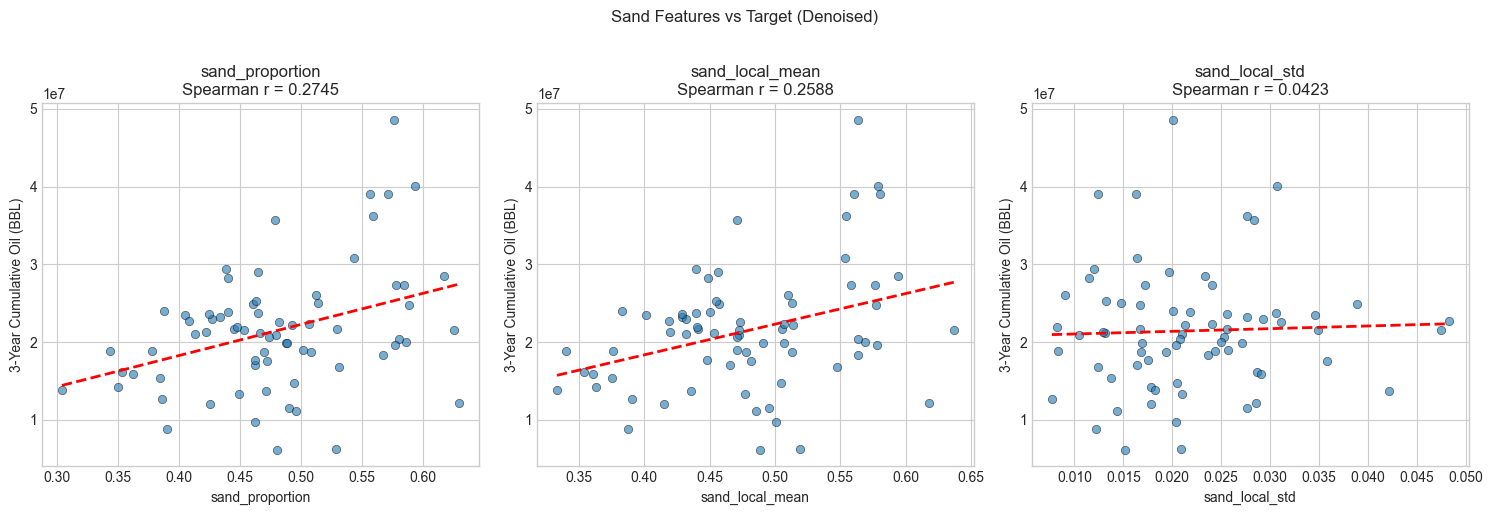

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feat in enumerate(sand_features):
    axes[i].scatter(training_data[feat], y, alpha=0.6, edgecolors='k', linewidth=0.5)
    z = np.polyfit(training_data[feat], y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(training_data[feat].min(), training_data[feat].max(), 100)
    axes[i].plot(x_line, p(x_line), 'r--', linewidth=2)
    corr = training_data[feat].corr(y, method='spearman')
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('3-Year Cumulative Oil (BBL)')
    axes[i].set_title(f'{feat}\nSpearman r = {corr:.4f}')
plt.suptitle('Sand Features vs Target (Denoised)', y=1.02)
plt.tight_layout()
plt.show()

## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

In [58]:
exclude_cols = ['Well_ID', 'X', 'Y', 'Cum_Oil_3yr']
all_features = [col for col in training_data.columns if col not in exclude_cols]
X_all = training_data[all_features].copy()
X_all = X_all.replace([np.inf, -np.inf], np.nan).fillna(X_all.median())
correlations = X_all.apply(lambda col: col.corr(y, method='spearman')).abs().sort_values(ascending=False)
print("TOP 20 FEATURES BY CORRELATION:")
print("="*50)
for i, (feat, corr) in enumerate(correlations.head(20).items()):
    sand_flag = " ← SAND" if 'sand' in feat.lower() else ""
    print(f"{i+1:2d}. {feat:<40} |r| = {corr:.4f}{sand_flag}")

TOP 20 FEATURES BY CORRELATION:
 1. AI_p50                                   |r| = 0.9381
 2. Vp_p50                                   |r| = 0.9373
 3. Ksat_p50                                 |r| = 0.9353
 4. rho_b_p50                                |r| = 0.9346
 5. Kdry_p50                                 |r| = 0.9313
 6. phi_p50                                  |r| = 0.9303
 7. perm_p50                                 |r| = 0.9302
 8. SI_p50                                   |r| = 0.9178
 9. perm_mean                                |r| = 0.9141
10. phi_mean                                 |r| = 0.9125
11. Gdry_p50                                 |r| = 0.9124
12. rho_b_mean                               |r| = 0.9123
13. Gsat_p50                                 |r| = 0.9109
14. RQI                                      |r| = 0.8901
15. AI_mean                                  |r| = 0.8888
16. Vs_p50                                   |r| = 0.8877
17. Vp_mean                             

## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

In [59]:
TOP_FEATURES = correlations.head(16).index.tolist()
sand_in_top = [f for f in TOP_FEATURES if 'sand' in f.lower()]
print(f"\nTOP 16 FEATURES SELECTED:")
for i, f in enumerate(TOP_FEATURES):
    sand_flag = " ★" if 'sand' in f.lower() else ""
    print(f"  {i+1:2d}. {f}{sand_flag}")
if sand_in_top:
    print(f"\n✓ Sand features included: {sand_in_top}")
else:
    print(f"\n✗ No sand features in top 16.")
    for feat in sand_features:
        if feat in correlations.index:
            rank = list(correlations.index).index(feat) + 1
            print(f"  {feat} ranks at position {rank}")


TOP 16 FEATURES SELECTED:
   1. AI_p50
   2. Vp_p50
   3. Ksat_p50
   4. rho_b_p50
   5. Kdry_p50
   6. phi_p50
   7. perm_p50
   8. SI_p50
   9. perm_mean
  10. phi_mean
  11. Gdry_p50
  12. rho_b_mean
  13. Gsat_p50
  14. RQI
  15. AI_mean
  16. Vs_p50

✗ No sand features in top 16.
  sand_proportion ranks at position 119
  sand_local_mean ranks at position 120
  sand_local_std ranks at position 133


## Correlation Analysis

Calculating the correlation between features and the target helps separate signal from noise. High correlation scores highlight the strongest predictors, while near-zero scores identify irrelevant data.

In [60]:
INCLUDE_SAND_THRESHOLD = 0.15
best_sand_feat = None
best_sand_corr = 0
for feat in sand_features:
    if feat in correlations.index and correlations[feat] > best_sand_corr:
        best_sand_corr = correlations[feat]
        best_sand_feat = feat
if best_sand_feat and best_sand_corr >= INCLUDE_SAND_THRESHOLD and best_sand_feat not in TOP_FEATURES:
    print(f"\nAdding {best_sand_feat} (|r| = {best_sand_corr:.4f}) to feature set.")
    TOP_FEATURES.append(best_sand_feat)
    if len(TOP_FEATURES) > 16:
        removed = TOP_FEATURES.pop(-2) 
        print(f"Removed {removed} to maintain 16 features.")
print(f"\nFinal feature count: {len(TOP_FEATURES)}")


Adding sand_proportion (|r| = 0.2745) to feature set.
Removed Vs_p50 to maintain 16 features.

Final feature count: 16


## Train-Test Split

Splitting the dataset ensures that the model is evaluated on unseen data. A hold-out set acts as a final exam to test how well the model generalizes to new wells.

In [61]:
X = training_data[TOP_FEATURES].copy()
y = training_data['Cum_Oil_3yr'].copy()
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Training: {X_train.shape[0]} wells (80%)")
print(f"Test: {X_test.shape[0]} wells (20%)")
print(f"Features: {X_train.shape[1]}")

Training: 56 wells (80%)
Test: 15 wells (20%)
Features: 16


## Model Training

A Gradient Boosting Regressor fits the training data. This algorithm iteratively corrects its own errors, learning non-linear relationships between the geological features and oil production.

In [62]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [5, 7, 10],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0.5, 1.0, 2.0],
    'reg_lambda': [2.0, 3.0, 5.0]
}
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print("Running hyperparameter search...")
xgb_base = xgb.XGBRegressor(random_state=RANDOM_STATE, verbosity=0)
random_search = RandomizedSearchCV(
    xgb_base, param_distributions=param_grid,
    n_iter=40, cv=cv, scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)
best_params = random_search.best_params_
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nBest CV RMSE: {-random_search.best_score_:,.0f} BBL")

Running hyperparameter search...

Best parameters:
  subsample: 0.6
  reg_lambda: 5.0
  reg_alpha: 2.0
  n_estimators: 150
  min_child_weight: 5
  max_depth: 4
  learning_rate: 0.1
  colsample_bytree: 0.8

Best CV RMSE: 3,725,936 BBL


## Model Training

A Gradient Boosting Regressor fits the training data. This algorithm iteratively corrects its own errors, learning non-linear relationships between the geological features and oil production.

In [63]:
xgb_model = xgb.XGBRegressor(
    **best_params,
    random_state=RANDOM_STATE,
    verbosity=0,
    early_stopping_rounds=15
)
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)
print(f"Training stopped at {xgb_model.best_iteration} iterations.")

Training stopped at 140 iterations.


### Performance Metrics

Quantifying error using RMSE (Root Mean Squared Error) and R² provides a concrete measure of accuracy. These metrics reveal how close the predictions are to the actual production figures.

In [64]:
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
r2_gap = train_r2 - test_r2
print("="*65)
print("MODEL PERFORMANCE")
print("="*65)
print(f"\n{'Metric':<15} {'Training (80%)':<22} {'Test (20%)':<22}")
print("-"*60)
print(f"{'RMSE':<15} {train_rmse:>18,.0f} BBL {test_rmse:>18,.0f} BBL")
print(f"{'R²':<15} {train_r2:>18.4f}     {test_r2:>18.4f}")
print(f"{'MAPE':<15} {train_mape:>18.2f} %   {test_mape:>18.2f} %")
print(f"\nOverfitting Gap: {r2_gap:.4f} (Original was 0.1925, target < 0.10)")

MODEL PERFORMANCE

Metric          Training (80%)         Test (20%)            
------------------------------------------------------------
RMSE                     1,794,251 BBL          2,625,318 BBL
R²                          0.9412                 0.9095
MAPE                          3.85 %                11.77 %

Overfitting Gap: 0.0317 (Original was 0.1925, target < 0.10)


### Data Visualization

Visual inspection of the data distribution highlights patterns and potential outliers that raw statistics might miss.

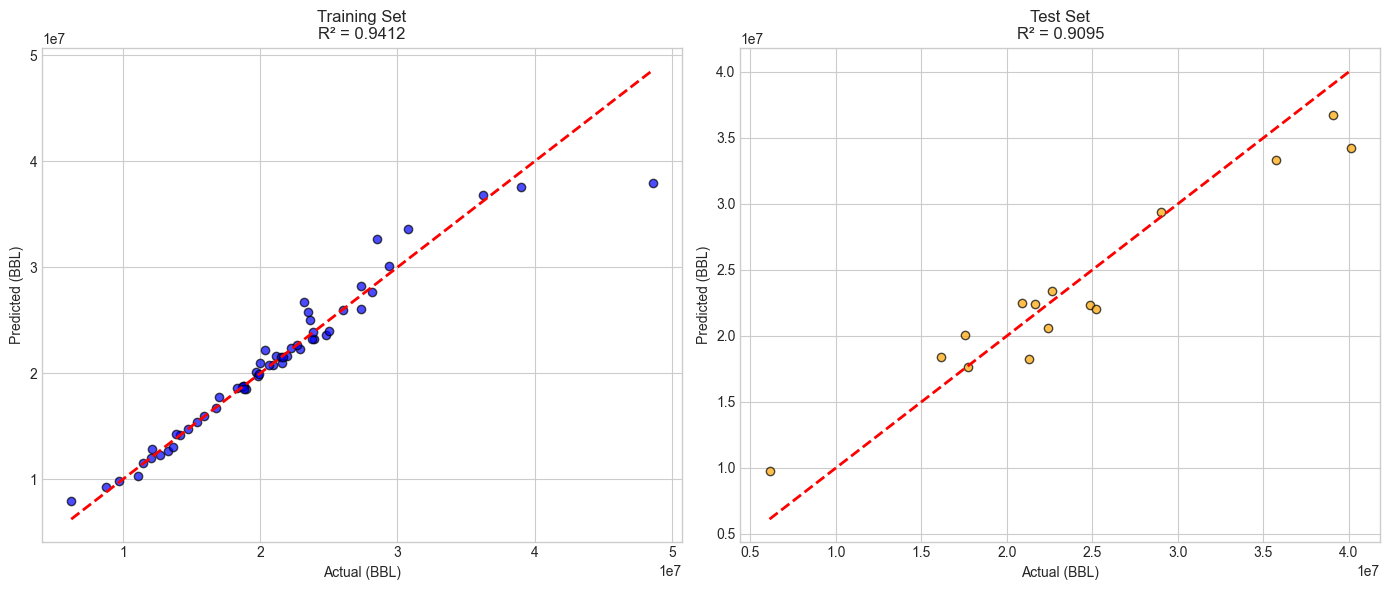

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(y_train, y_train_pred, alpha=0.7, c='blue', edgecolors='k')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual (BBL)')
axes[0].set_ylabel('Predicted (BBL)')
axes[0].set_title(f'Training Set\nR² = {train_r2:.4f}')
axes[1].scatter(y_test, y_test_pred, alpha=0.7, c='orange', edgecolors='k')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual (BBL)')
axes[1].set_ylabel('Predicted (BBL)')
axes[1].set_title(f'Test Set\nR² = {test_r2:.4f}')
plt.tight_layout()
plt.show()

### Feature Importance

Visualizing which features the model relied on most offers interpretability. This confirms whether the model is learning from geological reality or just fitting noise.

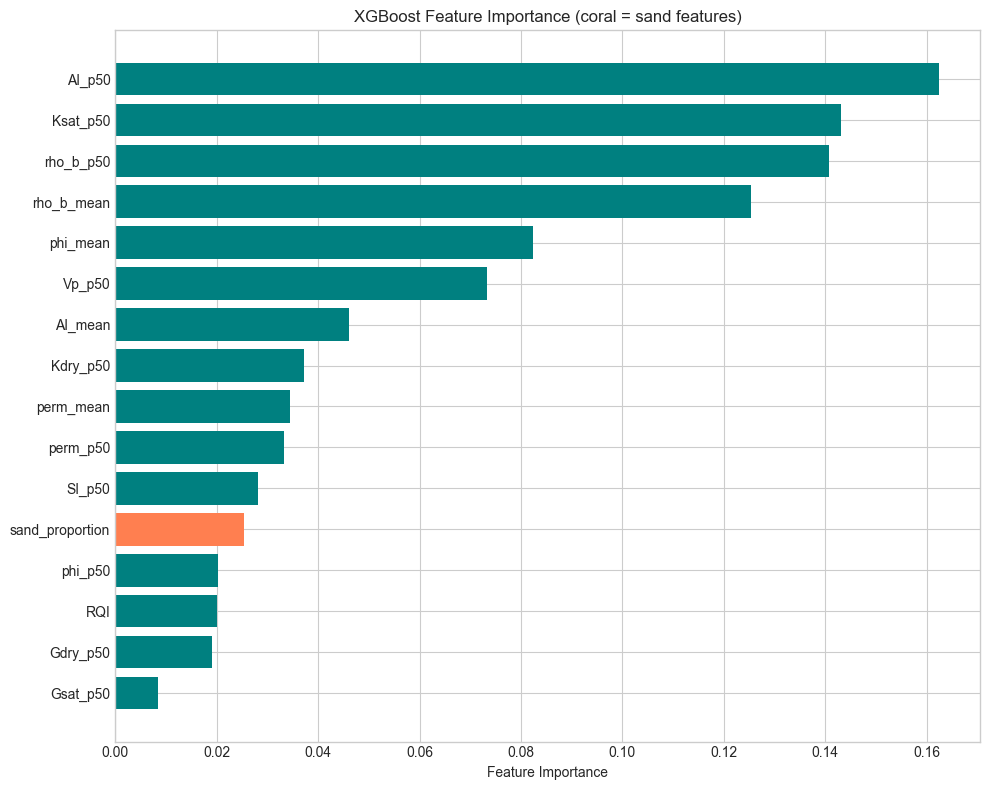


Feature Importance:
        Feature  Importance
         AI_p50    0.162384
       Ksat_p50    0.143091
      rho_b_p50    0.140820
     rho_b_mean    0.125391
       phi_mean    0.082376
         Vp_p50    0.073224
        AI_mean    0.046124
       Kdry_p50    0.037293
      perm_mean    0.034537
       perm_p50    0.033277
         SI_p50    0.028208
sand_proportion    0.025415
        phi_p50    0.020351
            RQI    0.020121
       Gdry_p50    0.019011
       Gsat_p50    0.008378


In [66]:
importance_df = pd.DataFrame({
    'Feature': TOP_FEATURES,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 8))
colors = ['coral' if 'sand' in f.lower() else 'teal' for f in importance_df['Feature']]
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (coral = sand features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
print("\nFeature Importance:")
print(importance_df.to_string(index=False))

## Model Training

A Gradient Boosting Regressor fits the training data. This algorithm iteratively corrects its own errors, learning non-linear relationships between the geological features and oil production.

In [67]:
X_full = training_data[TOP_FEATURES].copy()
y_full = training_data['Cum_Oil_3yr'].copy()
X_full = X_full.replace([np.inf, -np.inf], np.nan).fillna(X_full.median())
scaler_full = RobustScaler()
X_full_scaled = scaler_full.fit_transform(X_full)
xgb_final = xgb.XGBRegressor(**best_params, random_state=RANDOM_STATE, verbosity=0)
xgb_final.fit(X_full_scaled, y_full)
print(f"Final model trained on all {len(training_data)} wells.")

Final model trained on all 71 wells.


### Handling Missing Values

Filling gaps in the dataset ensures continuity and prevents errors during mathematical operations.

In [68]:
X_preprod = features_preprod[TOP_FEATURES].copy()
X_preprod = X_preprod.replace([np.inf, -np.inf], np.nan)
for col in X_preprod.columns:
    if X_preprod[col].isnull().any():
        X_preprod[col].fillna(X_full[col].median(), inplace=True)
X_preprod_scaled = scaler_full.transform(X_preprod)
well_ids_preprod = features_preprod['Well_ID'].values
print(f"Preproduction wells: {list(well_ids_preprod)}")

Preproduction wells: [np.int64(72), np.int64(73), np.int64(74), np.int64(75), np.int64(76), np.int64(77), np.int64(78), np.int64(79), np.int64(80), np.int64(81), np.int64(82), np.int64(83)]


## Model Training

A Gradient Boosting Regressor fits the training data. This algorithm iteratively corrects its own errors, learning non-linear relationships between the geological features and oil production.

In [69]:
N_REALIZATIONS = 100
predictions_matrix = np.zeros((len(X_preprod), N_REALIZATIONS))
residual_std = test_rmse * 0.3
print(f"Generating {N_REALIZATIONS} realizations...")
for i in range(N_REALIZATIONS):
    if (i + 1) % 25 == 0:
        print(f"  Progress: {i+1}/{N_REALIZATIONS}")
    np.random.seed(RANDOM_STATE + i)
    indices = np.random.choice(len(X_full_scaled), size=len(X_full_scaled), replace=True)
    X_boot = X_full_scaled[indices]
    y_boot = y_full.iloc[indices].values
    varied_params = best_params.copy()
    varied_params['subsample'] = np.clip(best_params.get('subsample', 0.7) + np.random.uniform(-0.1, 0.1), 0.5, 0.9)
    varied_params['colsample_bytree'] = np.clip(best_params.get('colsample_bytree', 0.7) + np.random.uniform(-0.1, 0.1), 0.5, 0.9)
    model = xgb.XGBRegressor(**varied_params, random_state=RANDOM_STATE + i, verbosity=0)
    model.fit(X_boot, y_boot)
    preds = model.predict(X_preprod_scaled)
    noise = np.random.normal(0, residual_std, size=len(preds))
    predictions_matrix[:, i] = preds + noise
predictions_matrix = np.maximum(predictions_matrix, 0)
print(f"\nDone!")

Generating 100 realizations...


  Progress: 25/100
  Progress: 50/100
  Progress: 75/100
  Progress: 100/100

Done!


### Calculation Logic

This block executes a specific mathematical transformation required to prepare the data for the next stage.

In [70]:
prediction_summary = pd.DataFrame({
    'Well_ID': well_ids_preprod,
    'Estimate': np.mean(predictions_matrix, axis=1),
    'P10': np.percentile(predictions_matrix, 10, axis=1),
    'P50': np.percentile(predictions_matrix, 50, axis=1),
    'P90': np.percentile(predictions_matrix, 90, axis=1),
    'Std': np.std(predictions_matrix, axis=1)
})
print("PREDICTION SUMMARY:")
print(prediction_summary.to_string(index=False))

PREDICTION SUMMARY:
 Well_ID     Estimate          P10          P50          P90          Std
      72 1.989609e+07 1.794443e+07 1.964207e+07 2.196030e+07 1.524535e+06
      73 2.222714e+07 2.074390e+07 2.228513e+07 2.356325e+07 1.101321e+06
      74 2.123453e+07 1.943685e+07 2.116191e+07 2.329968e+07 1.445894e+06
      75 3.092134e+07 2.808187e+07 3.101011e+07 3.389670e+07 2.380141e+06
      76 2.056789e+07 1.937592e+07 2.053594e+07 2.179323e+07 9.512741e+05
      77 1.952464e+07 1.826712e+07 1.963298e+07 2.084165e+07 1.055526e+06
      78 9.166006e+06 7.647932e+06 9.136142e+06 1.092268e+07 1.360105e+06
      79 1.473996e+07 1.332300e+07 1.483874e+07 1.611181e+07 1.074424e+06
      80 8.919191e+06 7.166782e+06 8.971334e+06 1.047152e+07 1.256600e+06
      81 1.278350e+07 1.139175e+07 1.284086e+07 1.419406e+07 1.090073e+06
      82 1.109300e+07 9.645025e+06 1.119834e+07 1.245550e+07 1.218697e+06
      83 1.648230e+07 1.501072e+07 1.648115e+07 1.795220e+07 1.257388e+06


## Submission Generation

The final step involves generating predictions for the test set and formatting them according to competition guidelines. This output file represents the final solution.

In [71]:
solution = pd.DataFrame()
solution['Well_ID'] = well_ids_preprod
solution['Prediction_BBL'] = np.mean(predictions_matrix, axis=1)
for i in range(N_REALIZATIONS):
    solution[f'R{i+1}'] = predictions_matrix[:, i]
solution.to_csv('solution.csv', index=False)
print("Saved: solution.csv")
print(f"Shape: {solution.shape}")

Saved: solution.csv
Shape: (12, 102)


### Calculation Logic

This block executes a specific mathematical transformation required to prepare the data for the next stage.

In [72]:
print("="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\n[SAND PROPORTION PROCESSING]")
print(f"  - Normalized to [0, 1]")
print(f"  - Applied median filter (3x3) + Gaussian smoothing (σ=0.5)")
print(f"  - Extracted: point value, local mean, local std")
sand_in_features = [f for f in TOP_FEATURES if 'sand' in f.lower()]
if sand_in_features:
    print(f"  - Sand features in model: {sand_in_features}")
else:
    print(f"  - Sand features did not rank in top 16")
print(f"\n[FEATURES] {len(TOP_FEATURES)} selected")
print(f"\n[PERFORMANCE]")
print(f"  Train R²: {train_r2:.4f}")
print(f"  Test R²:  {test_r2:.4f}")
print(f"  Overfitting Gap: {r2_gap:.4f}")
print(f"  Test RMSE: {test_rmse:,.0f} BBL")
print(f"\n[OUTPUT]")
print(f"  solution.csv with {N_REALIZATIONS} realizations")
print("\n" + "="*70)

FINAL SUMMARY

[SAND PROPORTION PROCESSING]
  - Normalized to [0, 1]
  - Applied median filter (3x3) + Gaussian smoothing (σ=0.5)
  - Extracted: point value, local mean, local std
  - Sand features in model: ['sand_proportion']

[FEATURES] 16 selected

[PERFORMANCE]
  Train R²: 0.9412
  Test R²:  0.9095
  Overfitting Gap: 0.0317
  Test RMSE: 2,625,318 BBL

[OUTPUT]
  solution.csv with 100 realizations

